# Real Estate Predictor

---

As is described in the README, this project focuses on the goals of a hypothetical real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the property to its resale, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

This project uses the [Ames housing data on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

Credit to <a href="https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset">Julien Cohen Solal</a> for some of the EDA techniques and other visualizations I used in this project.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Part 1: Estimating the value of homes from fixed characteristics.

---
The goal of this part is to build a reliable estimator for the sale price of the house given characteristics that cannot be changed or would require a "major" renovation. Some examples include:
- The neighborhood
- Square footage
- Number of bedrooms

Some examples of things that are renovate-able:
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything personally deemed modifiable without having to undergo major construction on the house.

---

### Steps to be completed for Part 1:
1. Remove any houses from the dataset that are not residential.
1. Perform any cleaning, feature engineering, and EDA deemed necessary.
1. Identify **fixed** features that can predict price.
1. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.  
    (Note: this is a project assignment specification, and random splitting of the dataset will be explored in next steps for this project.)
1. Characterize the model. How well does it perform? What are the best estimates of price?


In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape

(1460, 81)

### 1.1 - Remove any houses from the dataset that are not residential.

In [3]:
house = house.loc[house['MSZoning'].map(lambda x: 'R' in x)]
house.shape

(1385, 81)

### 1.2 - Perform any cleaning, feature engineering, and EDA you deem necessary.

In [4]:
house.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
421,422,20,RL,NaN,16635,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,215000
573,574,80,RL,76.0,9967,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,170000
958,959,20,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,WD,Normal,185000


**Note:** I will make Id the index for the dataframe. This way if new data is added later, I can match on Id.

In [5]:
# check that there are no duplicate Id's
len(house.Id.unique())

1385

In [6]:
# make Id column the index
house.set_index('Id', inplace=True)
house.sample(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
561,20,RL,NaN,11341,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,121500
204,120,RM,NaN,4438,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,149000
480,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca,89471


In [7]:
# preliminary check of datatypes and missing data
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1134 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
Alley            65 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
OverallQual      1385 non-null int64
OverallCond      1385 non-null int64
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non-null object
Exterior2nd      1385 non-

In [8]:
# returns columns with null values in descending order
def missing_values(df):
    missing = pd.DataFrame(df.isnull().sum(), columns=['Nulls'])
    missing['PercentNull'] = missing.Nulls / df.isnull().count() 
    return missing.sort_values(by='Nulls', ascending=False)

In [9]:
# look at the null value percentage for top 20 columns
missing = missing_values(house)
missing.head(20)

,Nulls,PercentNull
PoolQC,1378,0.994946
MiscFeature,1333,0.962455
Alley,1320,0.953069
Fence,1108,0.800000
FireplaceQu,641,0.462816
LotFrontage,251,0.181227
GarageYrBlt,79,0.057040
GarageCond,79,0.057040
GarageType,79,0.057040
GarageFinish,79,0.057040


#### Notes:  
- Of the columns with at least 15% of the data missing, I'm going to drop PoolQC (only 7 houses with pools and still have PoolArea), MiscFeature (only 54 homes with it and still have MiscVal), Alley, FireplaceQu (still have number of fireplaces), and LotFrontage. Fence is going to have the NA's recoded to NF for No Fence.
- For Electrical, MasVnrArea, MasVnrType, I'll just drop the rows where this value is missing since it's less than 1% of the data.
- The others need a little more investigation. I'll start with a correlation matrix for the numerical variables and box plots for the categorical ones.

In [10]:
# recode the nulls in Fence to reflect No Fence
house['Fence'] = house['Fence'].fillna('NF')

In [11]:
# drop the columns with more than 15% null entries
missing = missing_values(house)
house = house.drop(missing[missing['PercentNull'] > .15].index,1)

In [12]:
# drop the row where Electrical is null
house = house.drop(house.loc[house['Electrical'].isnull()].index)

In [13]:
# drop the rows where MasVnrArea or MasVnrType is null
mask = (house['MasVnrArea'].isnull()) | (house['MasVnrType'].isnull())
house = house.drop(house.loc[mask].index)
house.shape

(1379, 75)

**Note:**  
Maybe YearBuilt and GarageYrBlt are so strongly correlated that we can get away with only considering YearBuilt, since that doesn't have any nulls. I'll explore that here.

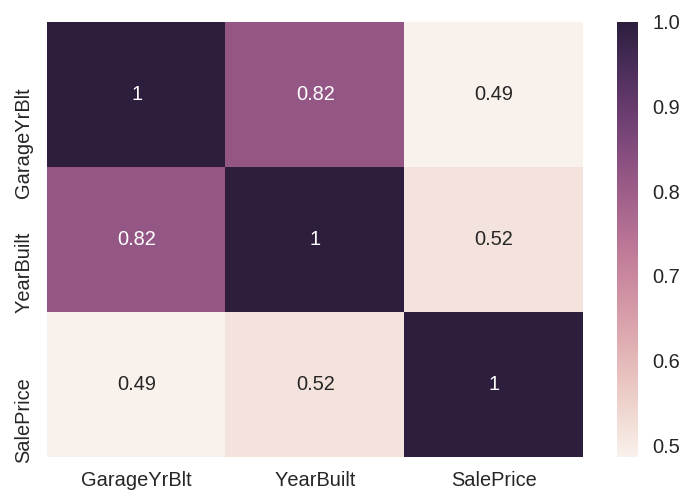

In [14]:
# look at correlation
sns.heatmap(house[['GarageYrBlt','YearBuilt','SalePrice']].corr(), annot=True)

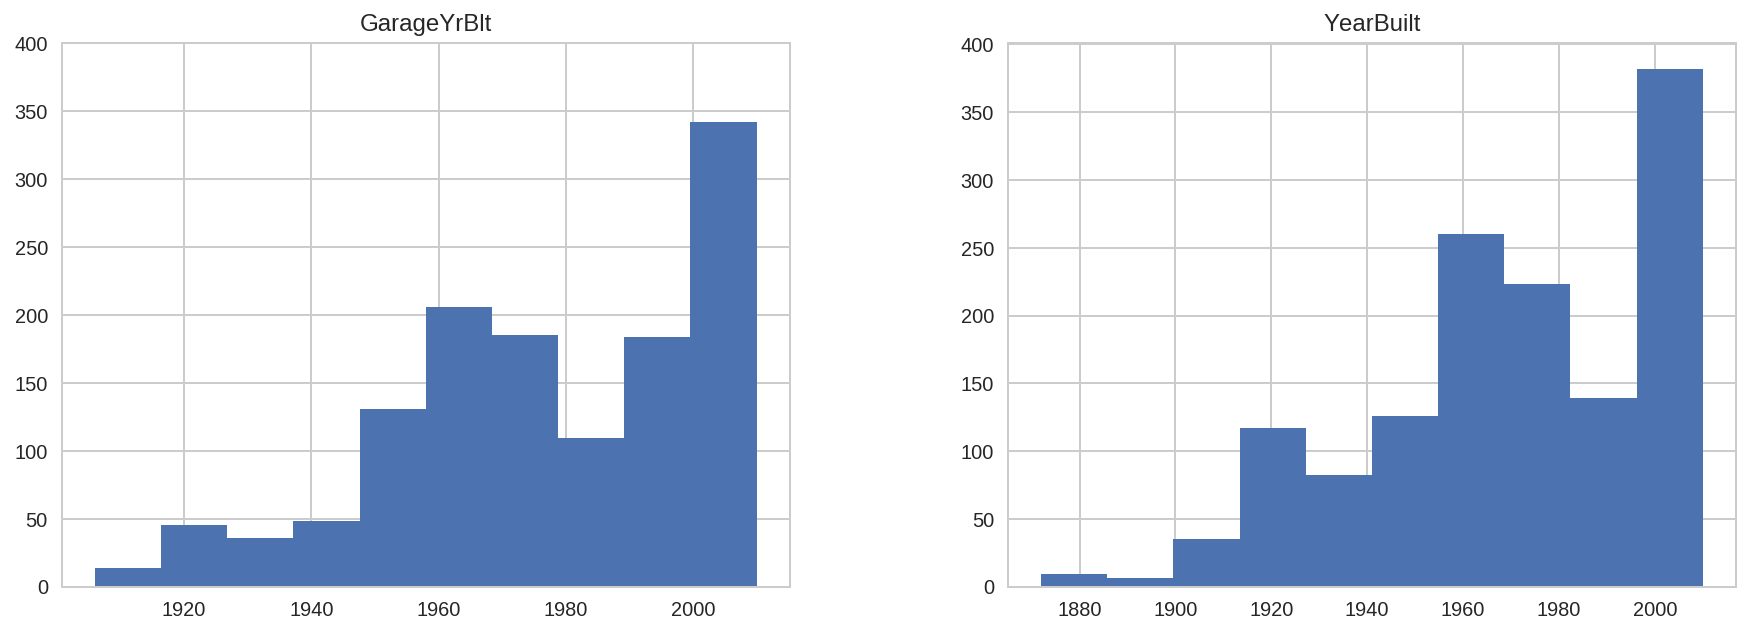

In [15]:
# graph the distributions
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
house[['GarageYrBlt']].hist(ax=ax1)
ax1.set_ylim(top=400)
house[['YearBuilt']].hist(ax=ax2)
plt.show()

In [16]:
# identify number of garages built after the house was built
sum(house['YearBuilt'] < house['GarageYrBlt'])

270

**Note:**  
Based on similarities in distributions and such a small percentage of garages built after the house, I'm comfortable dropping the GarageYrBlt column from the data.

In [17]:
house = house.drop('GarageYrBlt', axis=1)

In [18]:
# assign names of categorical columns to investigate
cat_cols = ['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtFinType2',
            'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']

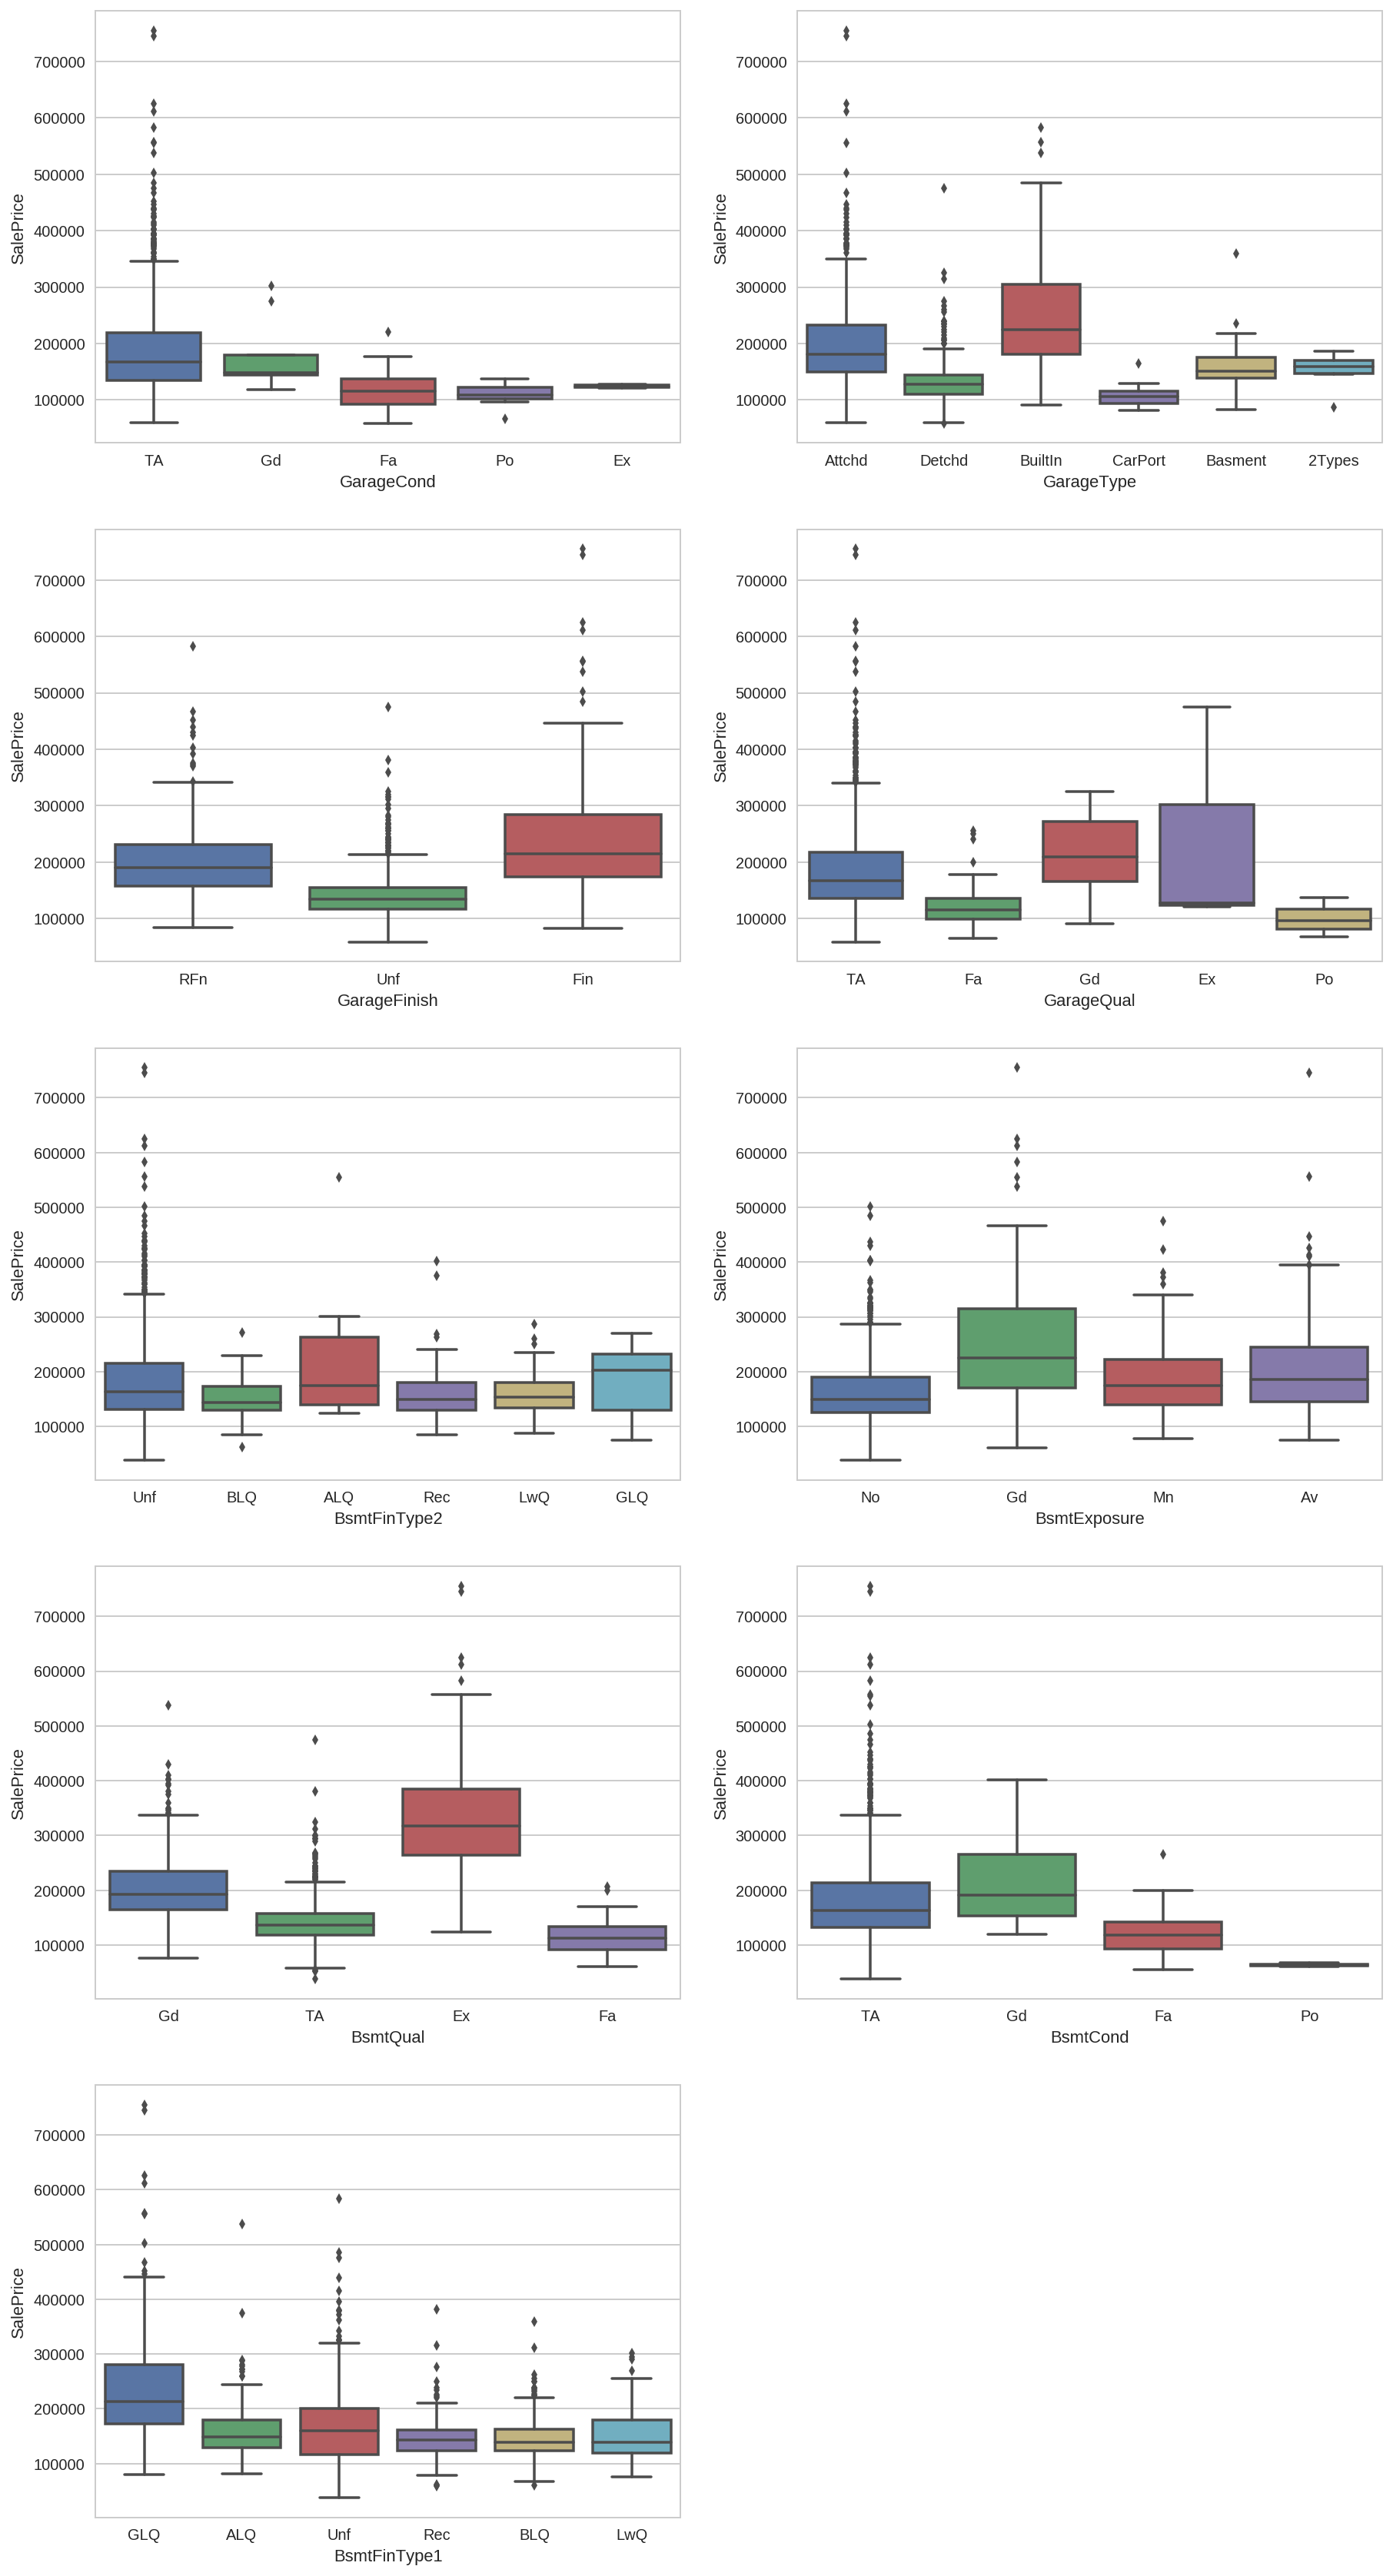

In [19]:
# create boxplots
fig = plt.figure(figsize=(15,30))
for i,col in enumerate(cat_cols):
    fig.add_subplot(521+i)
    sns.boxplot(x=col, y='SalePrice',data=house) 

**Note:**  
These columns seem to contain a significant number of outliers. With Garage info, there is still size in car capacity and size in square feet with complete data, so I'm okay dropping the Garage features plotted above. Regarding Basement info, the null values are an indication of no basement, so I'm going to fill them with 'NB' for No Basement. Many of these appear to have an influence on price, so I do not want to simply drop them.

In [20]:
house = house.drop(['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual'], axis=1)

In [21]:
# recode the basement nulls
cat_cols = ['BsmtFinType2','BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
for col in cat_cols:
    house[col] = house[col].fillna('NB')

In [22]:
# check to see if all missing values have been accounted for.
missing_values(house).head(2)

,Nulls,PercentNull
MSSubClass,0,0.0
BsmtFullBath,0,0.0


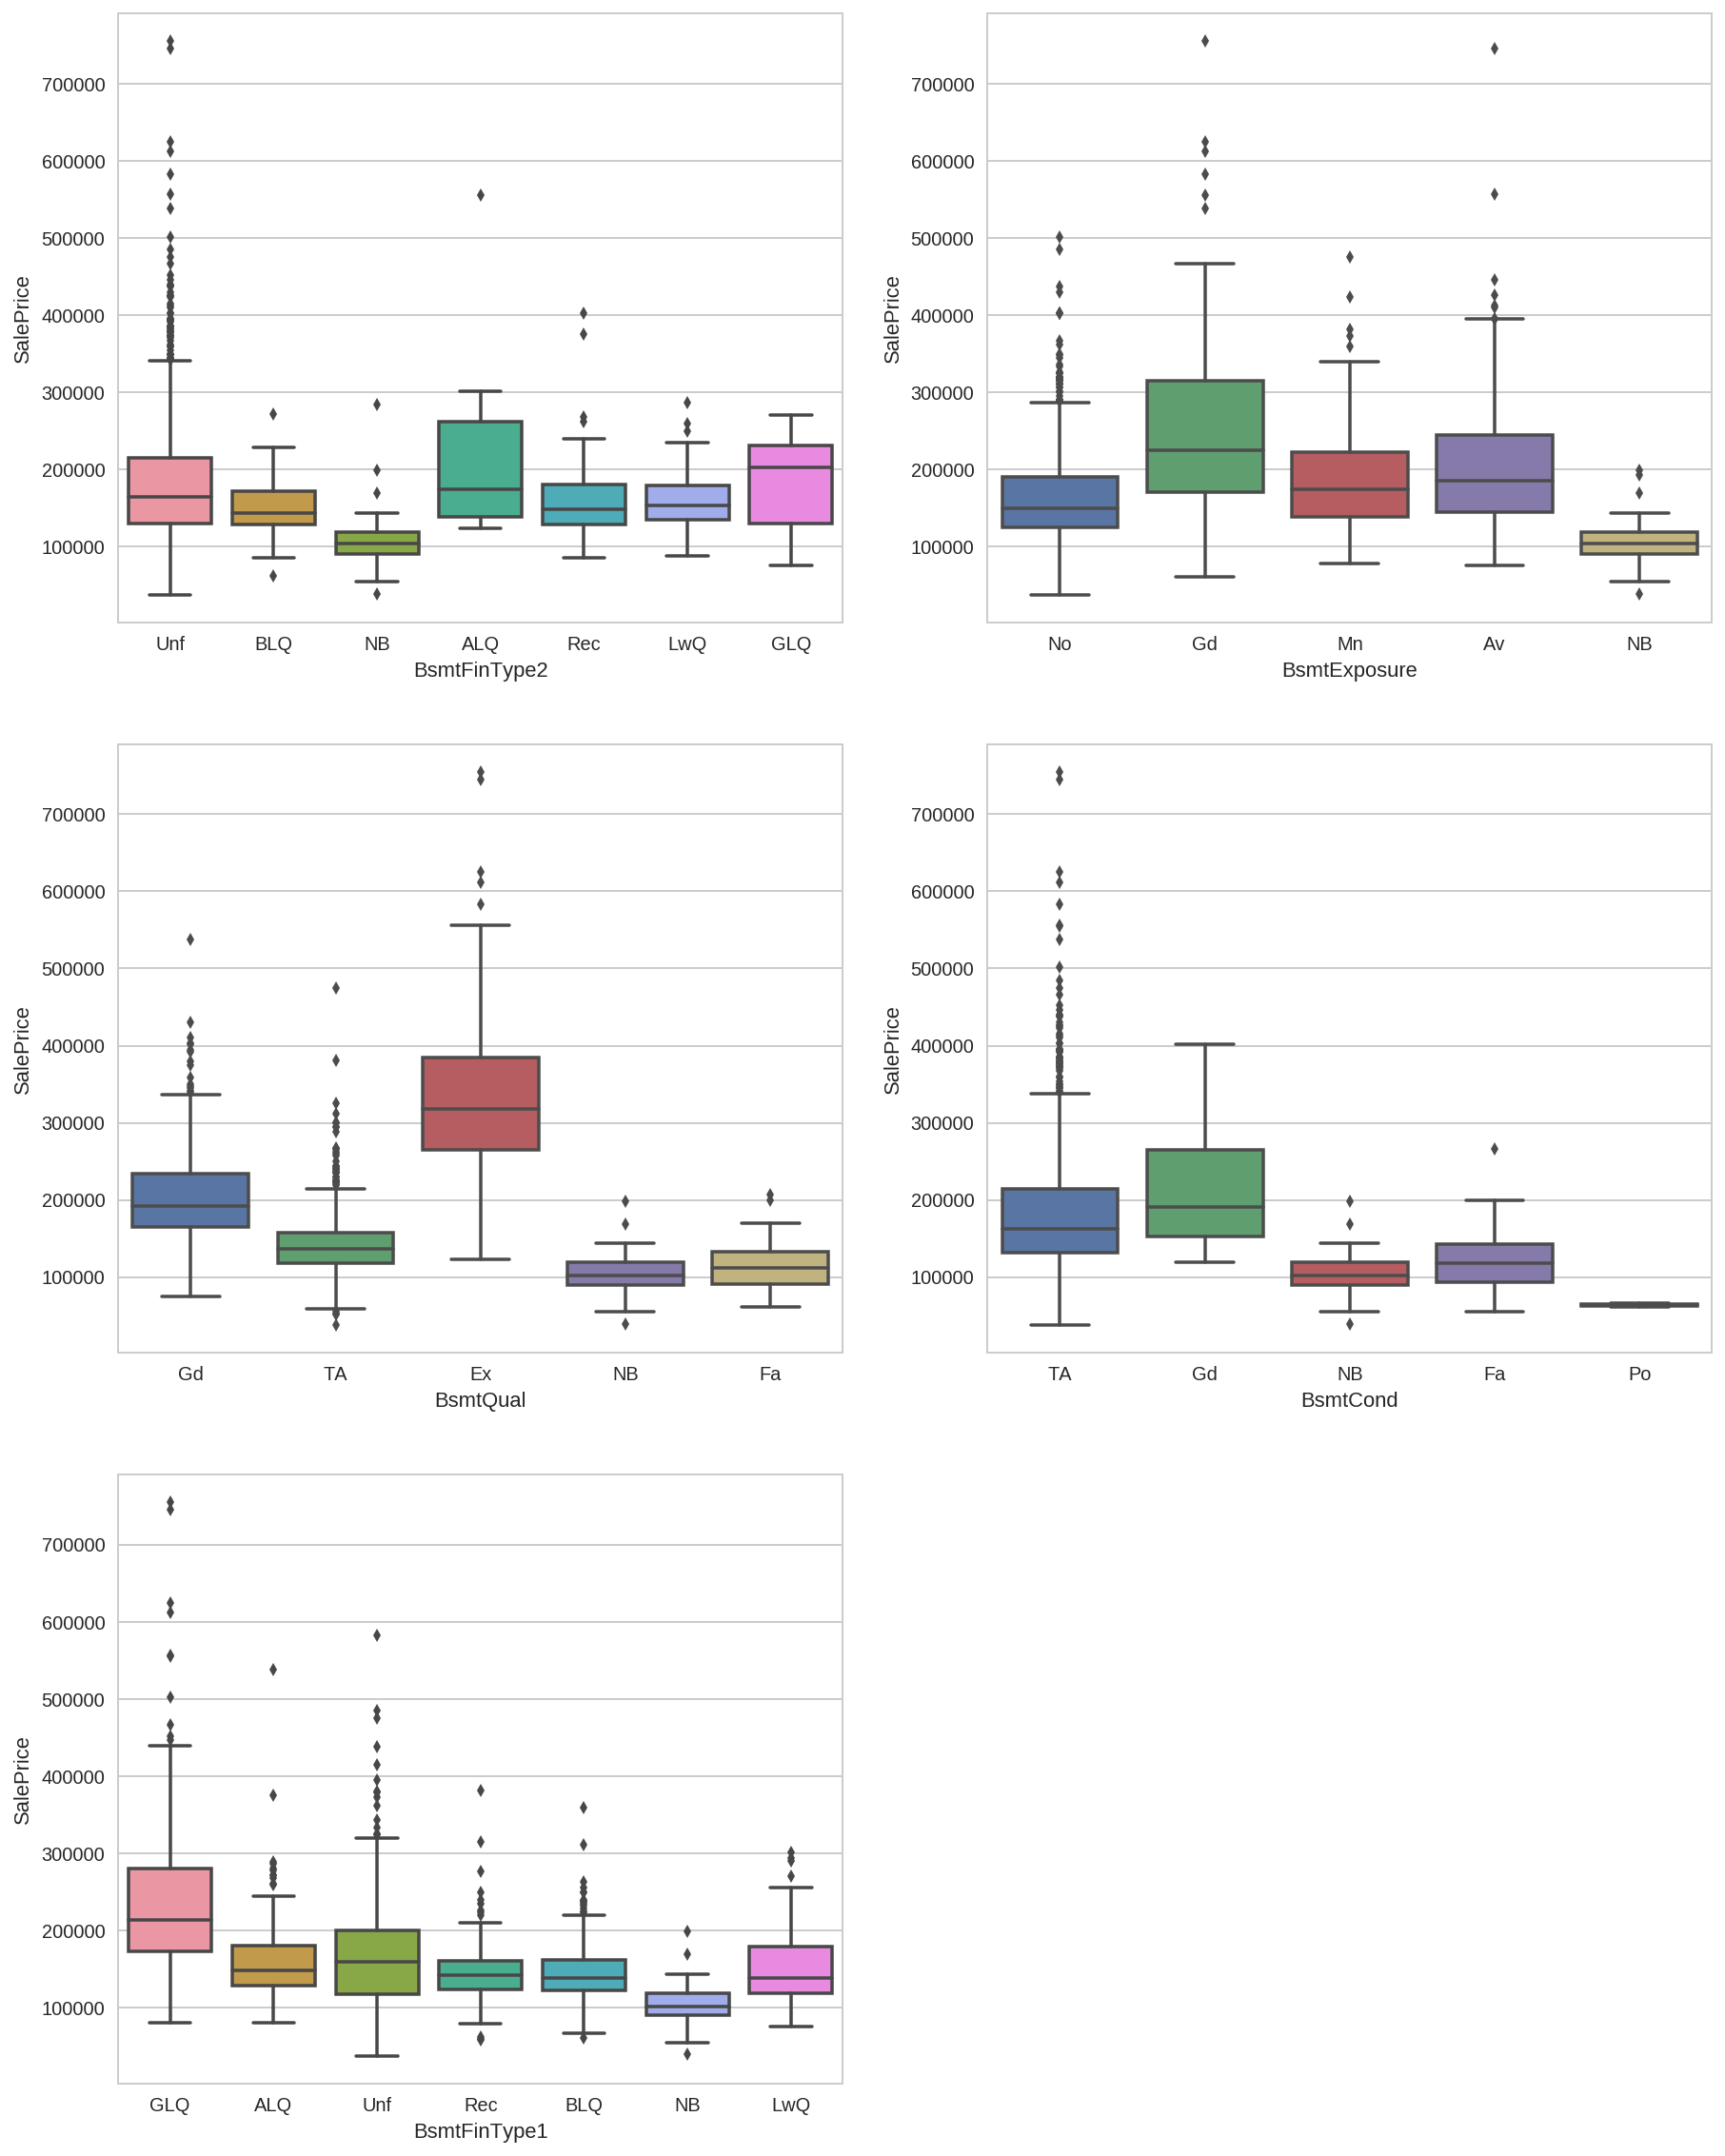

In [23]:
# look at basement box plots again now that nulls are gone
fig = plt.figure(figsize=(15,20))
for i,col in enumerate(cat_cols):
    fig.add_subplot(321+i)
    sns.boxplot(x=col, y='SalePrice',data=house)

**Note:**  
It appears that the absence of a basement does have an impact on sale price since in most of the cases above, the NB column appears to have the lowest average sale price in the group.

### Outliers  
In an effort to identify any outliers, let's look at some pair plots of SalePrice and the other numerical features.

In [24]:
# make separate column lists for categorical and numeric
categorical = [col for col in house.columns if house.dtypes[col] == 'object']
numeric = [col for col in house.columns if house.dtypes[col] != 'object']

# remove SalePrice from the list since it's the target and everything will be plotted against it
numeric.remove('SalePrice')

In [25]:
# check to make sure none were
1 + len(numeric) + len(categorical) == house.shape[1]

True

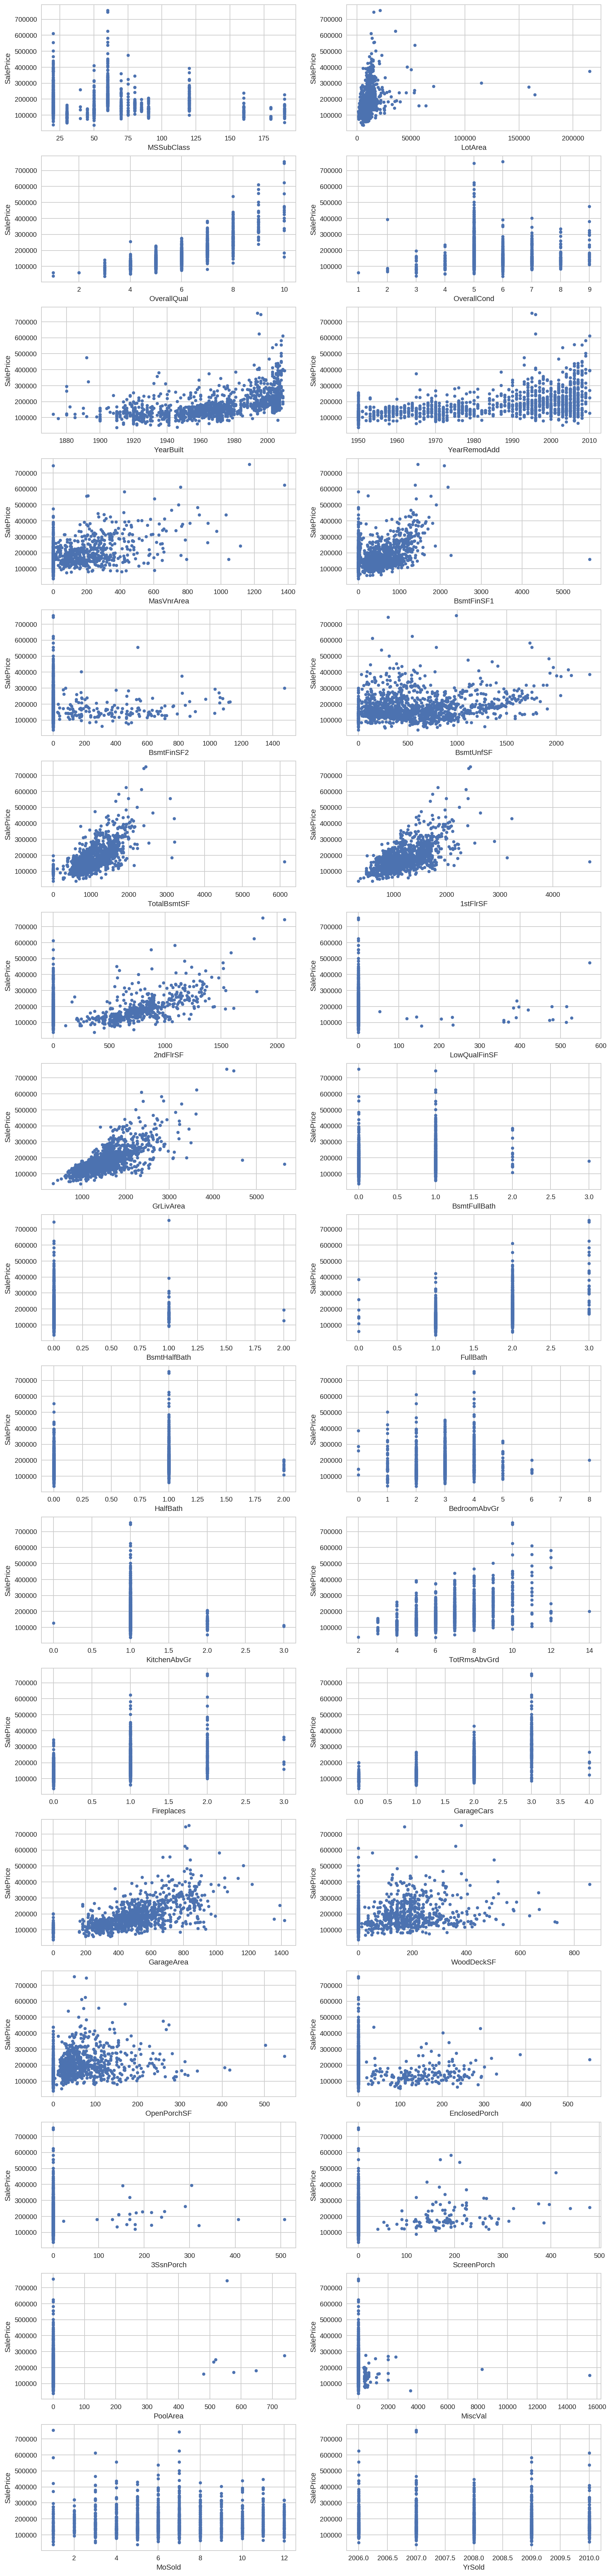

In [26]:
# graph each numerical column against SalePrice
fig, axes = plt.subplots(int(np.ceil(len(numeric)/2.0)), 2, figsize=(15,70))
for i,col in enumerate(numeric):
    house.plot.scatter(x=col, y='SalePrice', ax=axes[i//2,i%2])
plt.show()

**Note:**  
There are four properties above 4000 square feet (GrLivArea), and two of them seem to not follow the trend. I'm going to break up the numeric features into two types: continuous and discrete. The discrete will be treated as categorical for purpose of visualization (box plots) while the continuous will be explored further to identify outliers using the Tukey Method.

In [27]:
# printing for easier copying and pasting in next step
print(numeric)

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [28]:
# split numeric features into two sets
continuous = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
              'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
              'PoolArea', 'MiscVal']
discrete = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
            'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
            'MoSold', 'YrSold']

In [29]:
# check that none were missed
1+len(categorical)+len(continuous)+len(discrete) == house.shape[1]

True

In [30]:
# function that uses the Tukey method to identify outliers
def identify_outliers(dataframe, col):
    Q1 = np.percentile(dataframe[col], 25)
    Q3 = np.percentile(dataframe[col], 75)
    tukey_window = 1.5*(Q3-Q1)
    less_than_Q1 = dataframe[col] < Q1 - tukey_window
    greater_than_Q3 = dataframe[col] > Q3 + tukey_window
    tukey_mask = (less_than_Q1 | greater_than_Q3)
    return dataframe[tukey_mask]

In [31]:
# function to cleanly display the number of outliers for each feature
def display_outliers(df,cols):
    outlier_dict = {}
    for col in cols:
        out_df = identify_outliers(df,col)
        outlier_dict[col] = out_df.shape[0]
    return pd.DataFrame(list(outlier_dict.items()),
                        columns=['feature','total_outliers']).sort_values('total_outliers', ascending=False)

**Note:**  
Here is the number of outliers for each continuous feature. Next I'll account for the rows that are outliers in multiple features.

In [32]:
display_outliers(house,continuous)

,feature,total_outliers
13,EnclosedPorch,201
3,BsmtFinSF2,167
15,ScreenPorch,114
1,MasVnrArea,84
12,OpenPorchSF,73
0,LotArea,71
5,TotalBsmtSF,60
17,MiscVal,50
11,WoodDeckSF,31
9,GrLivArea,31


In [33]:
# this creates a list of indices for all outliers, including duplicates.
raw_outliers = []
for col in continuous:
    outlier_df = identify_outliers(house, col)
    raw_outliers += list(outlier_df.index)

In [34]:
# compare the total number of outliers to just the unique ones and total rows
print('Total outliers:', len(raw_outliers))
print('Unique outliers:', len(set(raw_outliers)))
print('Total rows:', house.shape[0])

Total outliers: 1004
Unique outliers: 683
Total rows: 1379


**Note:**  
Because nearly half of the rows in the data contain outliers, it doesn't make sense to me to remove them. Most of the literature I found on this data does suggest removing the two homes that are really large but have a low sale price. For the rest, at least for the numerical columns, I will check their skew and log transform those that are significantly skewed. 

In [35]:
# find and remove the two homes that are very large but have low sale price
mask = (house['GrLivArea'] > 4000) & (house['SalePrice'] < 300000)
house = house.drop(house.loc[mask].index)
house.shape

(1377, 70)

In [36]:
from scipy.stats import skew

In [37]:
# calculate skew of each numerical column (including SalePrice) and identify those greater than .75
skewed_features = house[numeric+['SalePrice']].apply(lambda x: skew(x))
skewed_features = skewed_features[abs(skewed_features) > .75]
print(str(skewed_features.shape[0]) + ' skewed numerical columns will be log transformed.')
skewed_features = skewed_features.index
print(skewed_features.get_values())

21 skewed numerical columns will be log transformed.
['MSSubClass' 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtHalfBath' 'HalfBath'
 'KitchenAbvGr' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch'
 'ScreenPorch' 'PoolArea' 'MiscVal' 'SalePrice']


In [38]:
# transform the skewed features identified above
house[skewed_features] = np.log1p(house[skewed_features])

**Note:**  
Let's look at the distribution of a few of the transformed features to see the effects of the transformation.

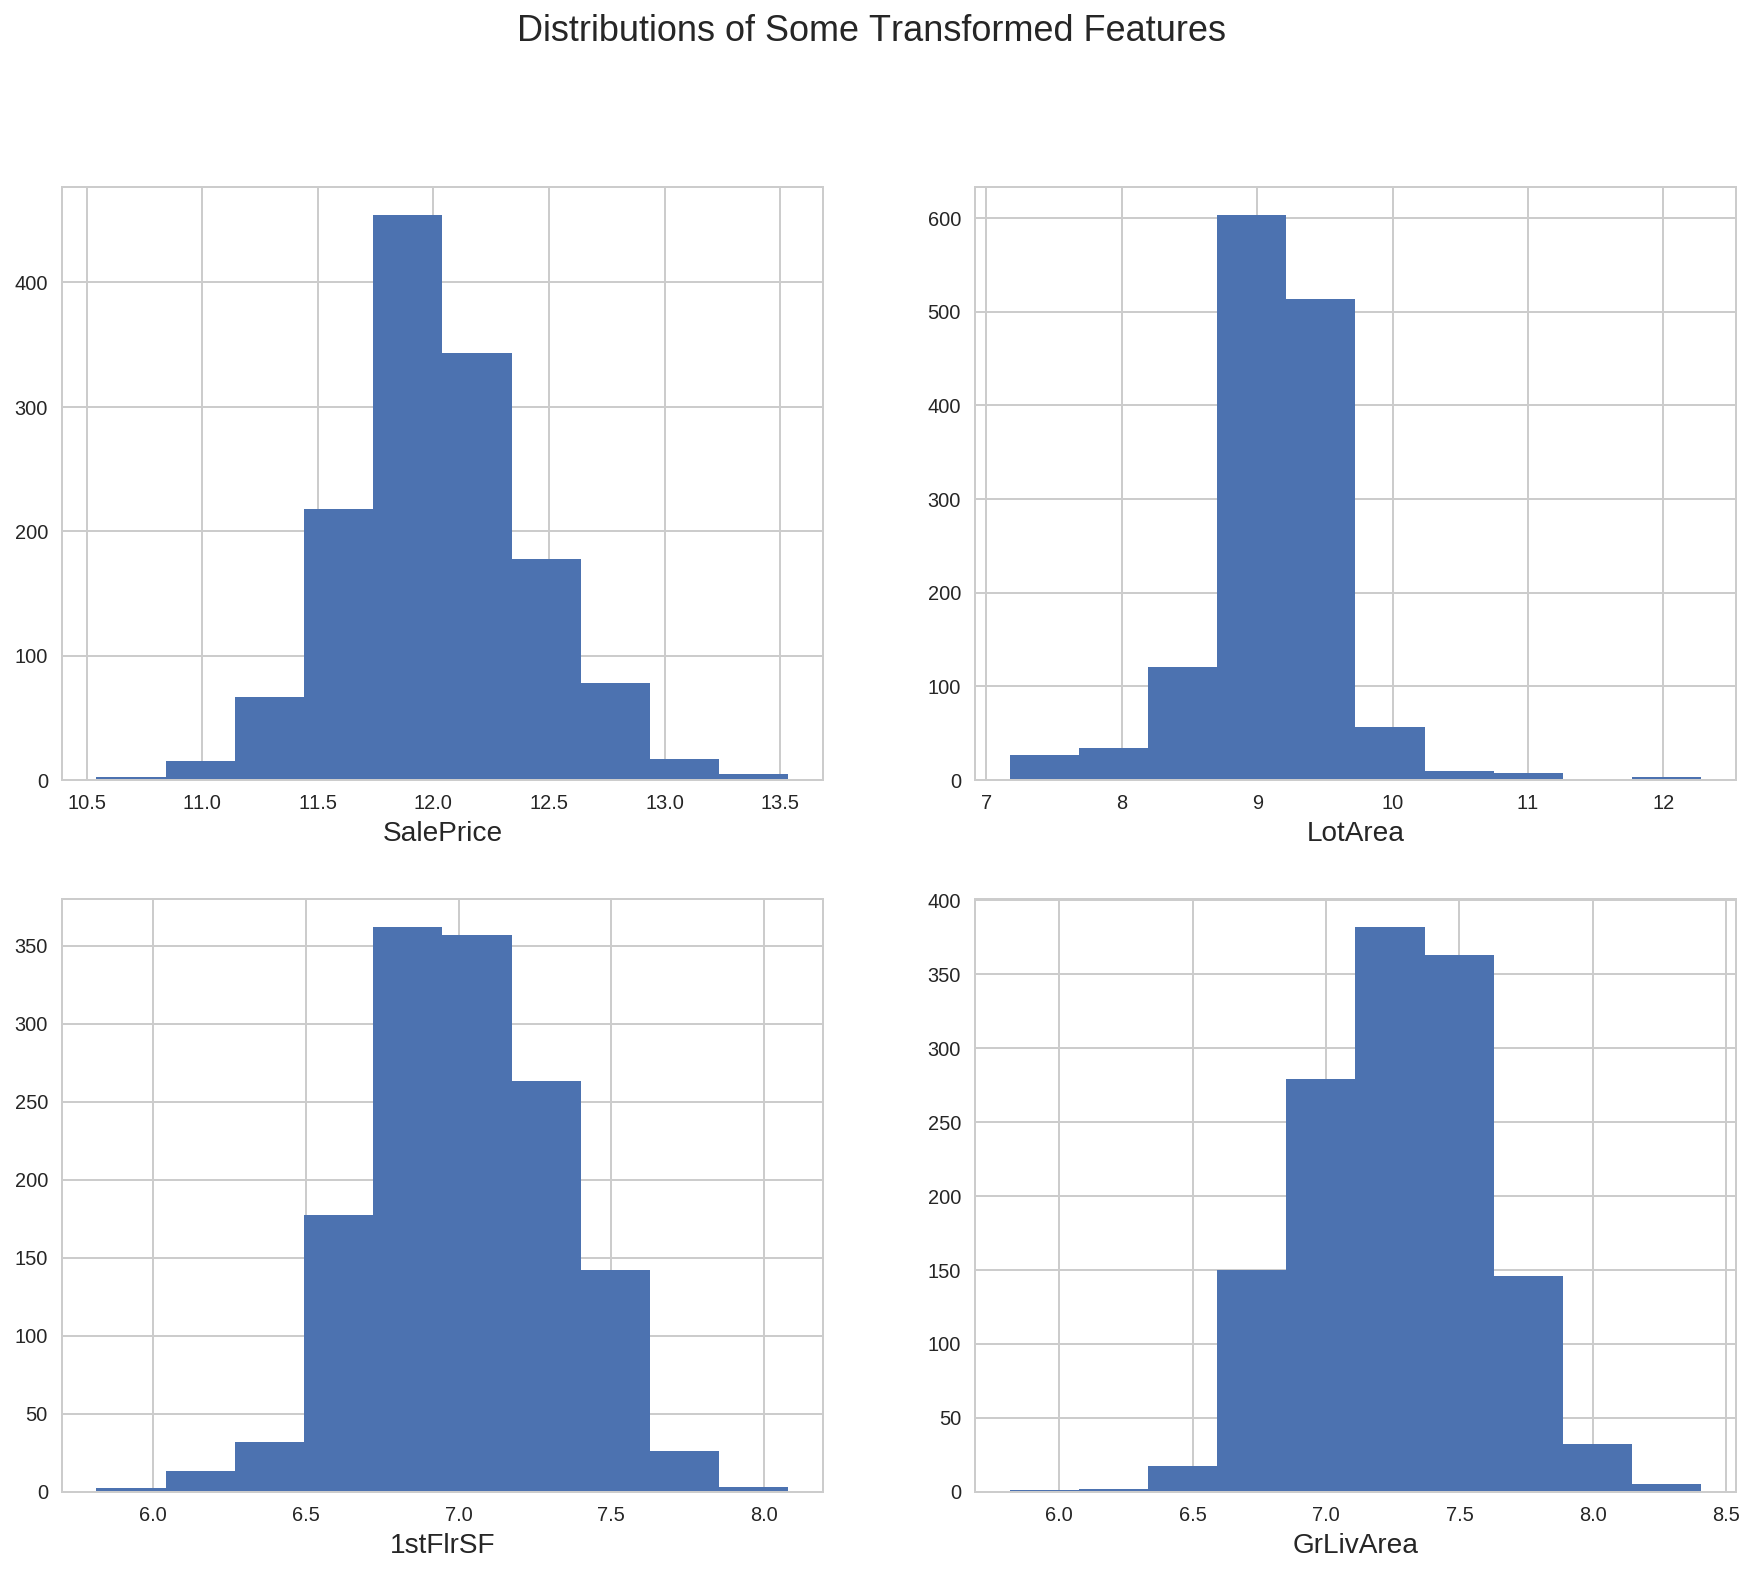

In [39]:
cols = ['SalePrice', 'LotArea', '1stFlrSF', 'GrLivArea']
fig = plt.figure(figsize=(15, len(cols)*3)) 
plt.suptitle('Distributions of Some Transformed Features', fontsize=18)
for i,col in enumerate(cols):
    ax = fig.add_subplot(221 + i)
    house[col].hist()
    ax.set_xlabel(col, fontsize=14)

**Note:**  
The graphs confirm that the log transformation has made the data less skewed, and it will reduce the affect of outliers.

### 1.3 - Identify fixed features that can predict price.  
These are selected based on my own interpretation and can certainly be split differently if desired.

In [40]:
# creating my lists of fixed features and fixable features
fixed_features = ['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                  'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
                  'RoofStyle', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
                  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
                  'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
fixable_features = ['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                    'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtFinType1', 'BsmtFinType2',
                    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'FullBath', 'HalfBath',
                    'KitchenQual', 'Functional', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence',  'MiscVal',]

In [41]:
# check that no features were missed (other than SalePrice)
1 + len(fixed_features) + len(fixable_features) == house.shape[1]

True

### 1.4 - Train a model on pre-2010 houses and evaluate its performance on the 2010 houses.

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [43]:
# create dataframe consisting of only fixed features
house_fixed = house.loc[:,fixed_features]

In [44]:
# convert all the categorical features to separate columns containing booleans
house_fixed = pd.get_dummies(house_fixed)
house_fixed.shape

(1377, 140)

In [45]:
# create masks to split training data from test data
train_mask = house['YrSold'] < 2010
test_mask = house['YrSold'] == 2010

In [46]:
# get the training set and check the sizes
X_train = house_fixed.loc[train_mask]
y_train = house.loc[train_mask].SalePrice
X_train.shape, y_train.shape

((1214, 140), (1214,))

In [47]:
# get the test set and check the sizes
X_test = house_fixed.loc[test_mask]
y_test = house.loc[test_mask].SalePrice
X_test.shape, y_test.shape

((163, 140), (163,))

### Lasso Regression
I will loop through Lasso models in order to tune the alpha parameter.

In [48]:
from sklearn.linear_model import Lasso

In [49]:
results = []
for a in np.arange(0.00035, 0.00046, 0.00001):
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    results.append({'alpha':a,
                    'train_score':lasso.score(X_train, y_train), 
                    'test_score':lasso.score(X_test, y_test)})
pd.DataFrame(results).T

,0,1,2,3,4,5,6,7,8,9,10
alpha,0.000350,0.000360,0.000370,0.000380,0.000390,0.000400,0.000410,0.000420,0.000430,0.000440,0.000450
test_score,0.905595,0.905623,0.905649,0.905667,0.905681,0.905692,0.905698,0.905698,0.905694,0.905678,0.905646
train_score,0.898471,0.898292,0.898109,0.897928,0.897743,0.897554,0.897372,0.897240,0.897104,0.896968,0.896831


**Note:**  
Based on the above table, it looks like alpha = 0.00041 or 0.00042 provides the best test score. This model performs better than the linear regression model, and I suspect it has done so with fewer features. Let's look at the coefficients and confirm that.

In [50]:
# fit the Lasso with alpha = 0.00041
lasso = Lasso(alpha=0.00041)
lasso.fit(X_train, y_train)

Lasso(alpha=0.00041, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

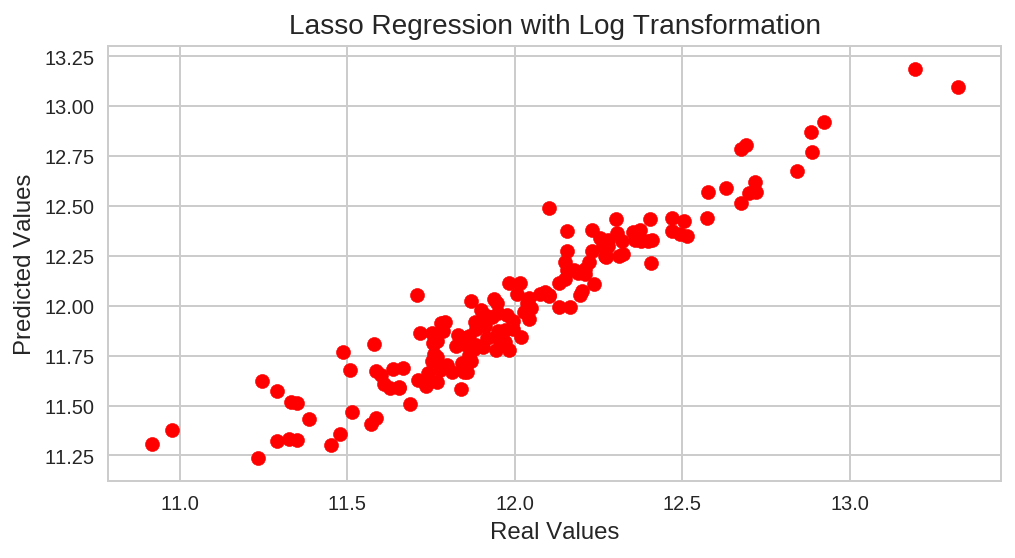

In [51]:
# scatter plot of actual values vs predicted values
y_test_pred = lasso.predict(X_test)
fig = plt.figure(figsize=(8,4))
plt.title('Lasso Regression with Log Transformation', fontsize=14)
plt.scatter(y_test, y_test_pred, c = 'red')
plt.xlabel('Real Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.show()

In [52]:
# look at which features were eliminated
coefs_lasso = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso eliminated {} of the {} original features.".format(sum(coefs_lasso == 0), len(coefs_lasso)))
print('Eliminated:', coefs_lasso[coefs_lasso == 0].index.get_values())

Lasso eliminated 70 of the 140 original features.
Eliminated: ['MSSubClass' '1stFlrSF' 'MSZoning_RH' 'MSZoning_RL' 'Street_Grvl'
 'Street_Pave' 'LotShape_IR1' 'LotShape_IR3' 'LandContour_Bnk'
 'LandContour_HLS' 'LandContour_Lvl' 'Utilities_AllPub' 'Utilities_NoSeWa'
 'LotConfig_FR3' 'LandSlope_Mod' 'Neighborhood_Blmngtn'
 'Neighborhood_Blueste' 'Neighborhood_BrDale' 'Neighborhood_ClearCr'
 'Neighborhood_CollgCr' 'Neighborhood_IDOTRR' 'Neighborhood_NPkVill'
 'Neighborhood_SWISU' 'Neighborhood_SawyerW' 'Neighborhood_Timber'
 'Condition1_Feedr' 'Condition1_PosA' 'Condition1_PosN' 'Condition1_RRAn'
 'Condition1_RRNe' 'Condition1_RRNn' 'Condition2_Artery' 'Condition2_Feedr'
 'Condition2_Norm' 'Condition2_PosA' 'Condition2_PosN' 'Condition2_RRAe'
 'Condition2_RRAn' 'Condition2_RRNn' 'BldgType_2fmCon' 'BldgType_Twnhs'
 'HouseStyle_1Story' 'HouseStyle_2.5Fin' 'HouseStyle_2.5Unf'
 'HouseStyle_SLvl' 'RoofStyle_Flat' 'RoofStyle_Gambrel' 'RoofStyle_Hip'
 'RoofStyle_Mansard' 'RoofStyle_Shed' 'Found

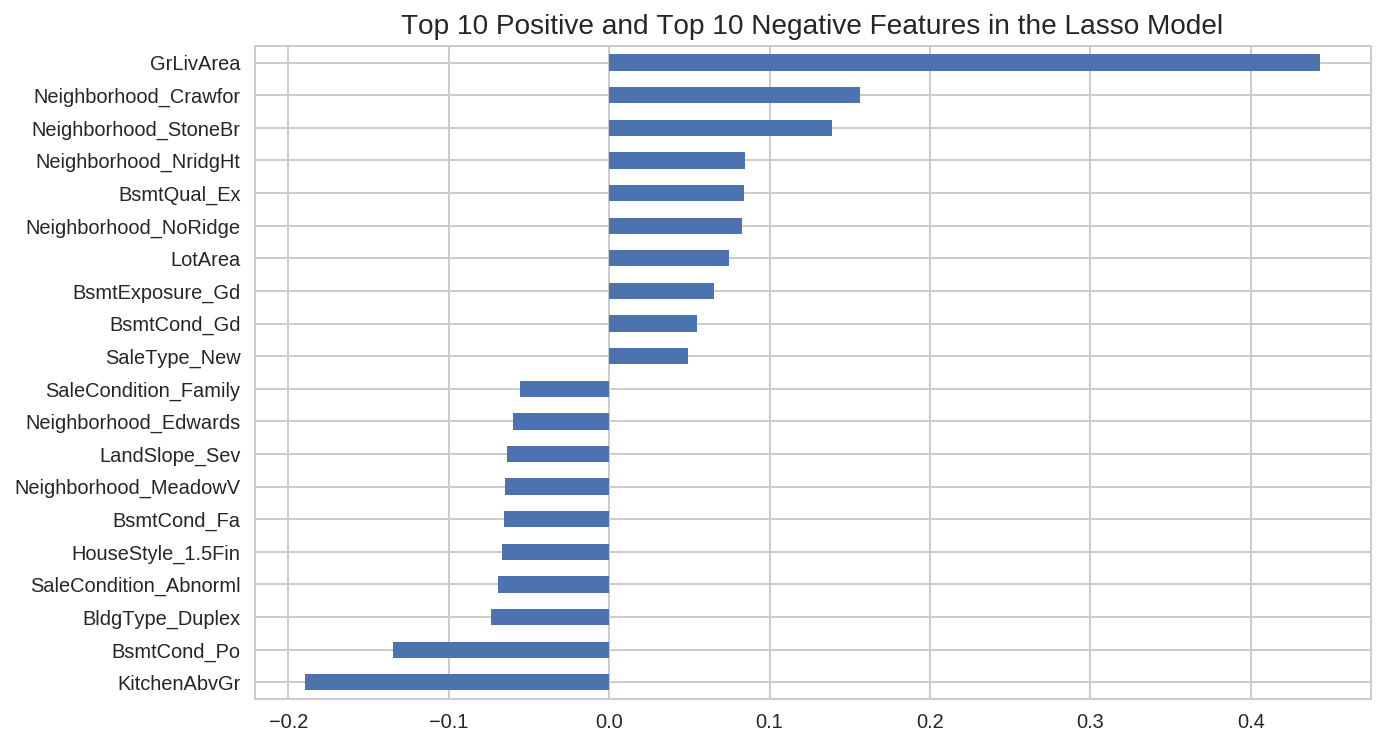

In [53]:
# look at the features that impact the model the most
top20_coefs_lasso = pd.concat([coefs_lasso.sort_values(ascending=True).head(10),
                        coefs_lasso.sort_values(ascending=True).tail(10)])
fig = plt.figure(figsize=(10,6))
top20_coefs_lasso.plot(kind = "barh")
plt.title("Top 10 Positive and Top 10 Negative Features in the Lasso Model", fontsize=14)
plt.show()

**Note:**  
The Lasso identified GrLivArea as top positive contributor and identified 3 top neighborhoods. It also identified KitchenAbvGr and BsmtCond_Po (poor basement) as the biggest detractors from sale price. While I'm pleased with the Lasso model score, for the sake of comparison I'm going to try a RandomForest model now.

### RandomForest

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [55]:
# create pipeline for scaling and fitting
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regr', RandomForestRegressor())
])

# list of hyperparameters to tune
rf_params = {
    'regr__n_estimators': [125, 150, 175],
    'regr__max_features': ['auto', 'log2']
}

rf_gs = GridSearchCV(rf_pipe, rf_params, cv=5, n_jobs=-1)

In [56]:
# fit the model and check the results
rf_gs.fit(X_train, y_train)
print(rf_gs.score(X_train, y_train))
print(rf_gs.score(X_test, y_test))
rf_gs.best_params_

0.980848790469
0.877189659782


{'regr__max_features': 'auto', 'regr__n_estimators': 175}

**Note:**  
Now that I have the best parameters, I will fit the model again to see which features this model listed as most important. Even though the score is slightly less than the Lasso, I'm still curious to see the features.

In [57]:
rf = RandomForestRegressor(n_estimators=175)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=175, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

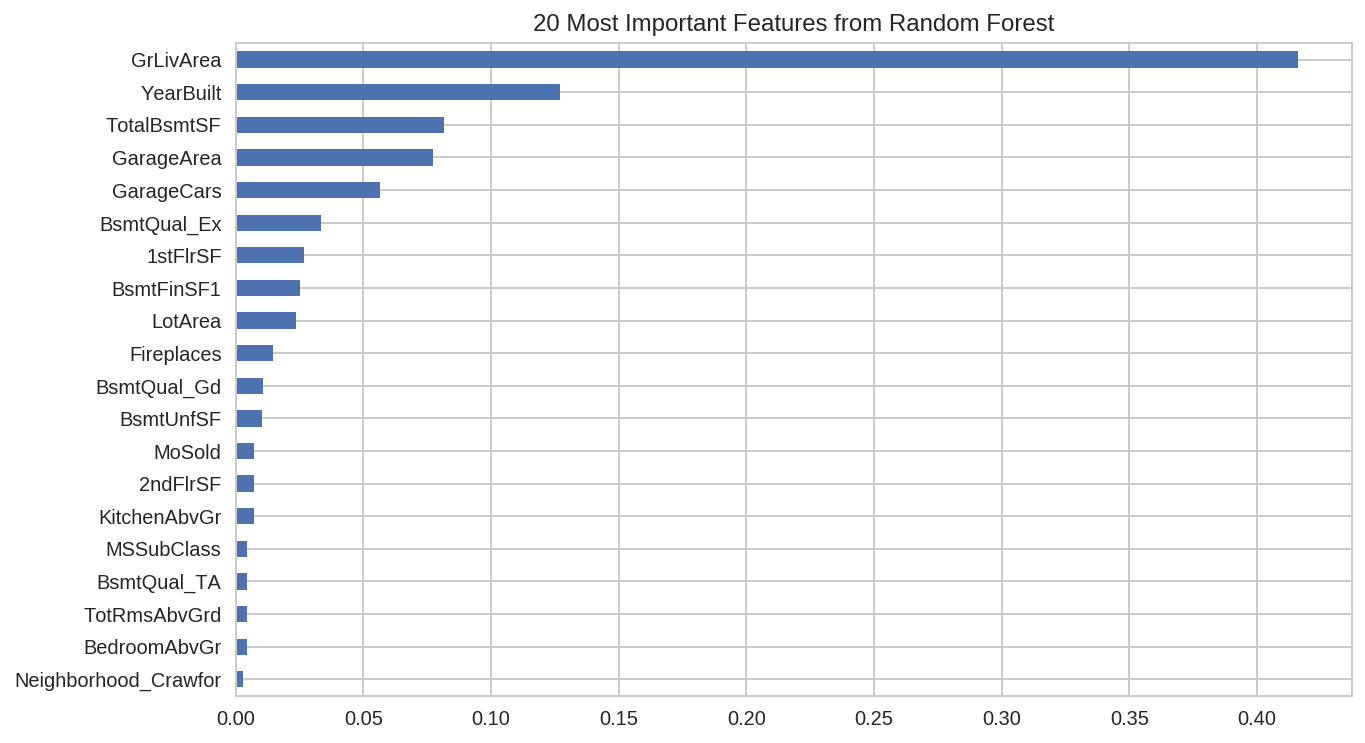

In [58]:
# look at most influential features for the random forest model
rf_feats = pd.Series(rf.feature_importances_, index = X_train.columns)
fig = plt.figure(figsize=(10,6))
rf_feats.sort_values().tail(20).plot(kind='barh')
plt.title('20 Most Important Features from Random Forest')
plt.show()

**Note:**  
The random forest model comes up a little shy in score comparison to the Lasso. What is reassuring is that GrLivArea is yet again at the top of the list as the most important feature. 

### 1.5 - Characterize the model. How well does it perform? What are the best estimates of price?

**Answer:**  
The model that performed the best was the Lasso. Not only does it provide the best score, but it also uses fewer features than the other models I tried.

As you can see in the graph below, the best estimators of price according to my model are GrLivArea (above ground living area), Neighborhood_Crawfor (Crawford Neighborhood), Neighborhood_StoneBr (Stone Bridge Neighborhood), BsmtCond_Po (severe cracking, settling or wetness in the basement), and KitchenAbvGr (number of kitchens above gound level). The first three influence price positively and the last two have negative influence. Overall, the following neighborhoods seem to have a positive impact on price: Crawford, Stone Brook, Northridge Heights. Meadow Village is the neighborhood that appears to most negatively impact sale price.

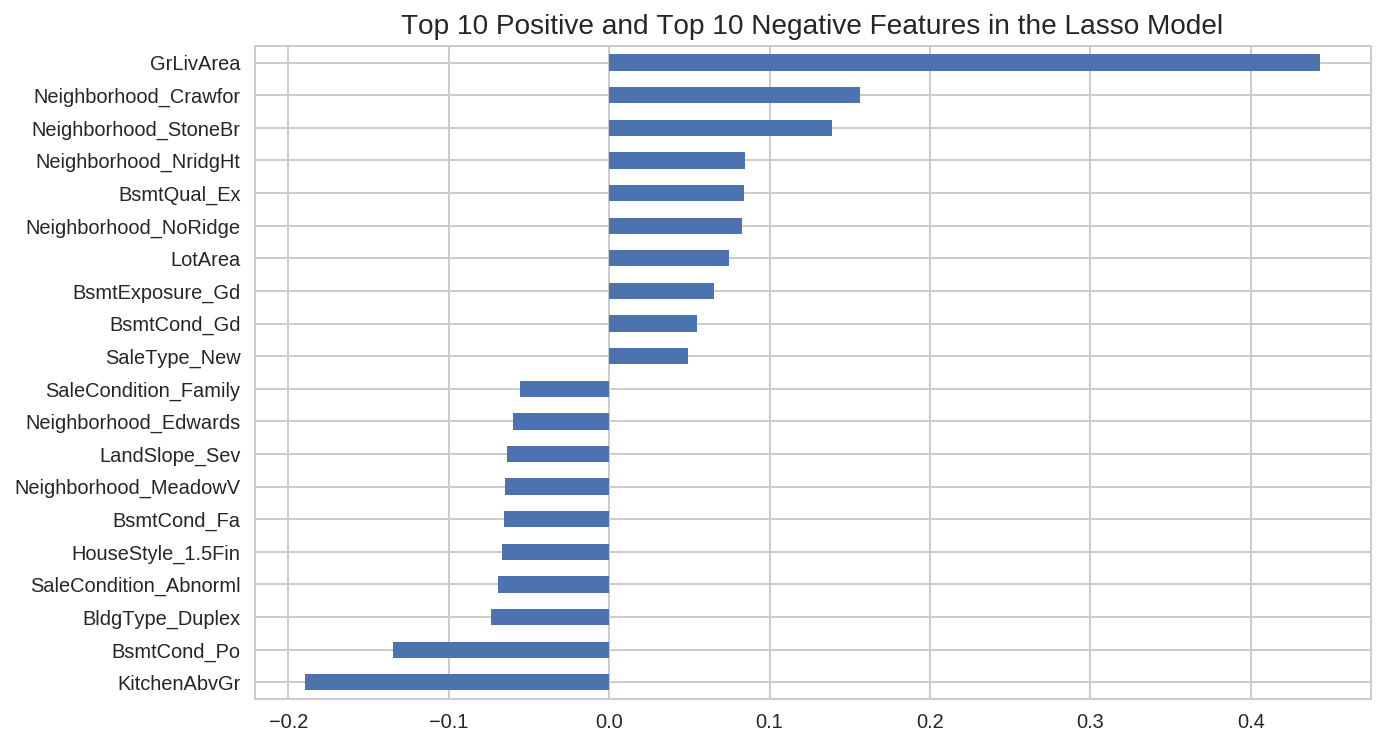

In [59]:
fig = plt.figure(figsize=(10,6))
top20_coefs_lasso.plot(kind = "barh")
plt.title("Top 10 Positive and Top 10 Negative Features in the Lasso Model", fontsize=14)
plt.show()

### Results Metrics

In [60]:
# create a dataframe with actual prices and predicted prices
results_df = pd.DataFrame({'actual_log_price': y_test, 'predicted_log_price':y_test_pred})
results_df.head()

,actual_log_price,predicted_log_price
Id,,
17,11.911708,11.896522
25,11.944714,11.778022
27,11.811555,11.668044
28,12.631344,12.590888
34,12.016733,12.115882


In [61]:
# convert the transformed prices back to non-transformed values
results_df['actual_price'] = results_df.actual_log_price.apply(lambda x: int(np.expm1(x)))
results_df['predicted_price'] = results_df.predicted_log_price.apply(lambda x: int(round(np.expm1(x),0)))
results_df.head()

,actual_log_price,predicted_log_price,actual_price,predicted_price
Id,,,,
17,11.911708,11.896522,149000,146754
25,11.944714,11.778022,153999,130355
27,11.811555,11.668044,134800,116779
28,12.631344,12.590888,305999,293868
34,12.016733,12.115882,165499,182750


**Metric:**  
On many housing price predictors, mean absolute percent error (MAPE) appears to be the favored metric. This metric measures the absolute difference between actual and predicted as a percentage for each house and then returns the average.

$$ MAPE = \frac{100}{n}\sum_{k=1}^n\left|\frac{Actual_k - Predicted_k}{Actual_k}\right| $$

In [62]:
# calculate the MAPE for non-transformed prices
np.mean(np.abs((results_df.actual_price - results_df.predicted_price) / results_df.actual_price)) * 100

9.3155513719388594

### Results Summary  
I'm pretty pleased with a MAPE of 9.3% considering that the team of data scientists at Zillow (the leading online real estate site) currently has a MAPE of 4% with their Zestimate model. 

## 2. Determine any value of *fixable* property characteristics unexplained by the *fixed* ones.

---

Now that there is a model that estimates the price of a house based on its static characteristics, we can move forward with next part of the plan: what are the costs/benefits of quality, condition, and renovations?

There were two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
1. The effects must be on the variance in price remaining from the first model.

---

### Steps to be completed for Part 2:
1. Split fixable features into categorical, discrete and continuous.
1. Use Part 1 model to get predictions for every house then add residual column to the dataframe.  
1. Do some EDA with fixable features and residuals.
1. Subset the data to just fixable features and get dummy variables.
1. Split the data into train and test sets and fit models with residuals as the target.
1. Summarize the findings.

### 2.1 - Split fixable features into categorical, discrete and continuous.

In [63]:
# split features for purpose of EDA
fixable_categorical = [col for col in house[fixable_features].columns if house.dtypes[col] == 'object']
fixable_numeric = [col for col in house[fixable_features].columns if house.dtypes[col] != 'object']

# look at numeric for purpose of further splitting
print(fixable_numeric)

['OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'LowQualFinSF', 'FullBath', 'HalfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [64]:
fixable_discrete = ['OverallQual', 'OverallCond', 'YearRemodAdd', 'FullBath', 'HalfBath']

fixable_continuous = ['MasVnrArea', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [65]:
# check to make sure I got them all
print(len(fixable_features) == len(fixable_categorical) + len(fixable_numeric))
print(len(fixable_numeric) == len(fixable_discrete) + len(fixable_continuous))

True
True


### 2.2 - Use Part 1 model to get predictions for every house then add residual column to the dataframe.  

In [66]:
# make dummy variables for fixed-features so that I can use Part 1 model
X = pd.get_dummies(house[fixed_features])

In [67]:
# make predicted sale prices a series so indices match the data
y_pred = pd.Series(lasso.predict(X), index=X.index)

In [68]:
# add the new columns
house['residual'] = house['SalePrice'] - y_pred

### 2.3 - Do some EDA with fixable features and residuals.

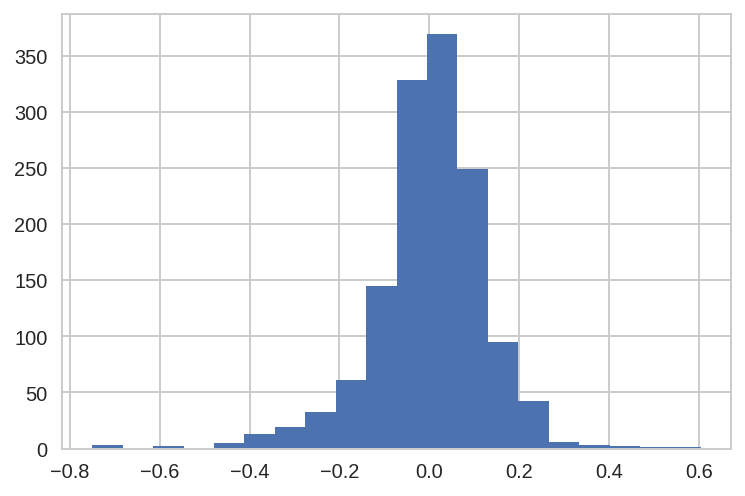

In [69]:
# check distribution of the target
house['residual'].hist(bins=20)

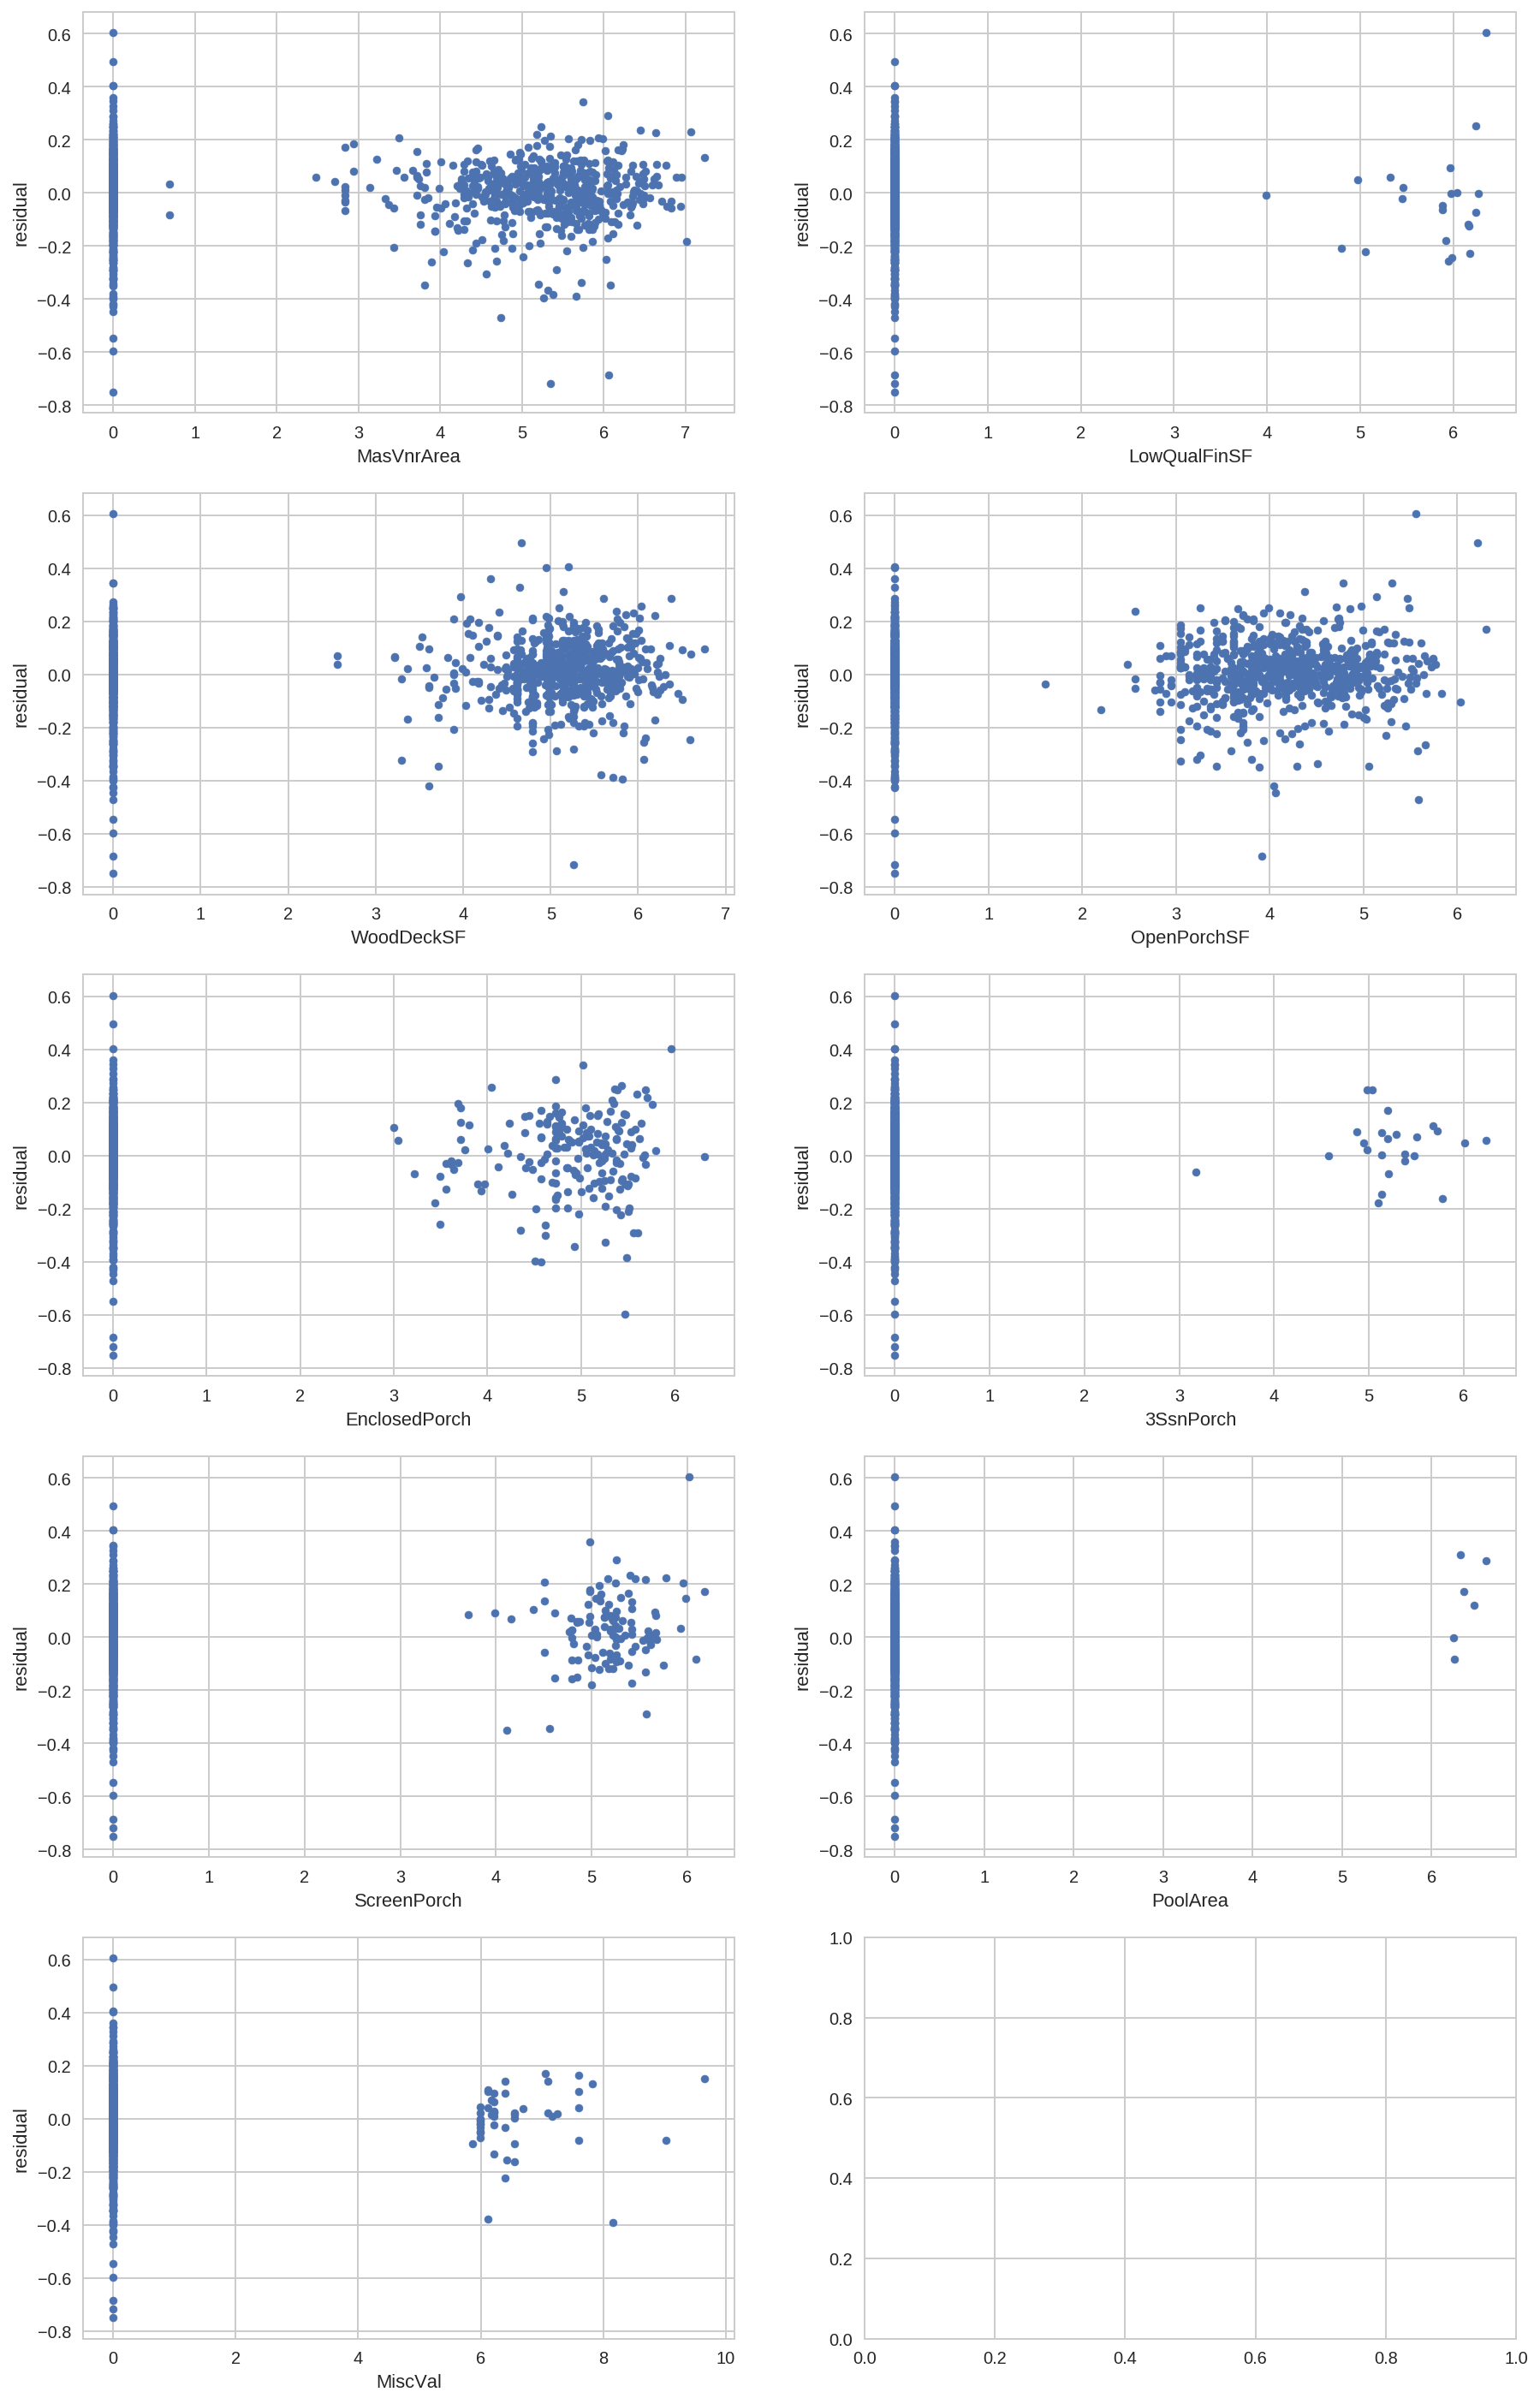

In [70]:
# pair plots of continuous fixable features and residuals
n_rows =int(np.ceil(len(fixable_continuous)/2.0))
fig, axes = plt.subplots(n_rows, 2, figsize=(15,5*n_rows))
for i,col in enumerate(fixable_continuous):
    house.plot.scatter(x=col, y='residual', ax=axes[i//2,i%2])
plt.show()

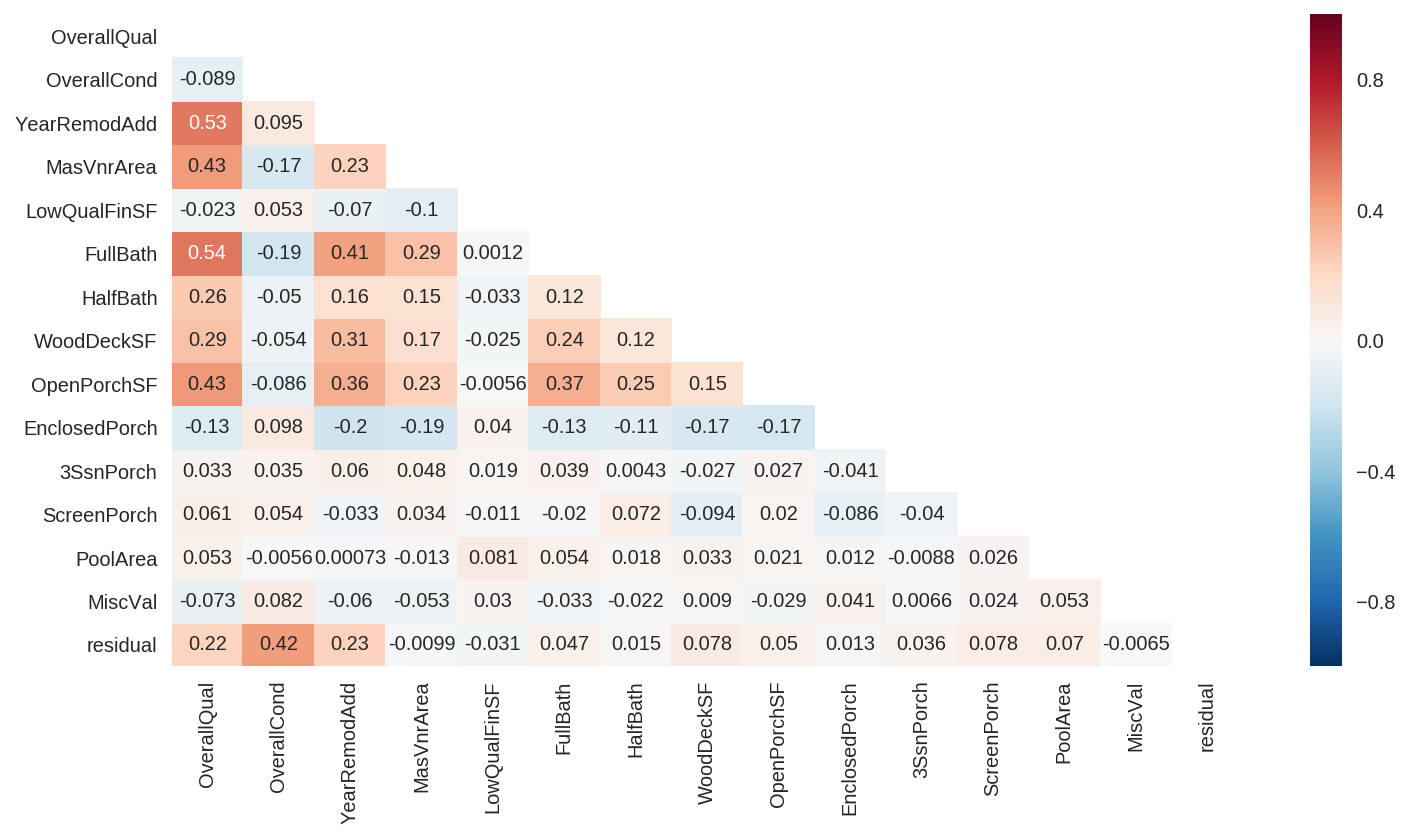

In [71]:
fig = plt.figure(figsize=(12,6))
corr = house[fixable_features+['residual']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show()

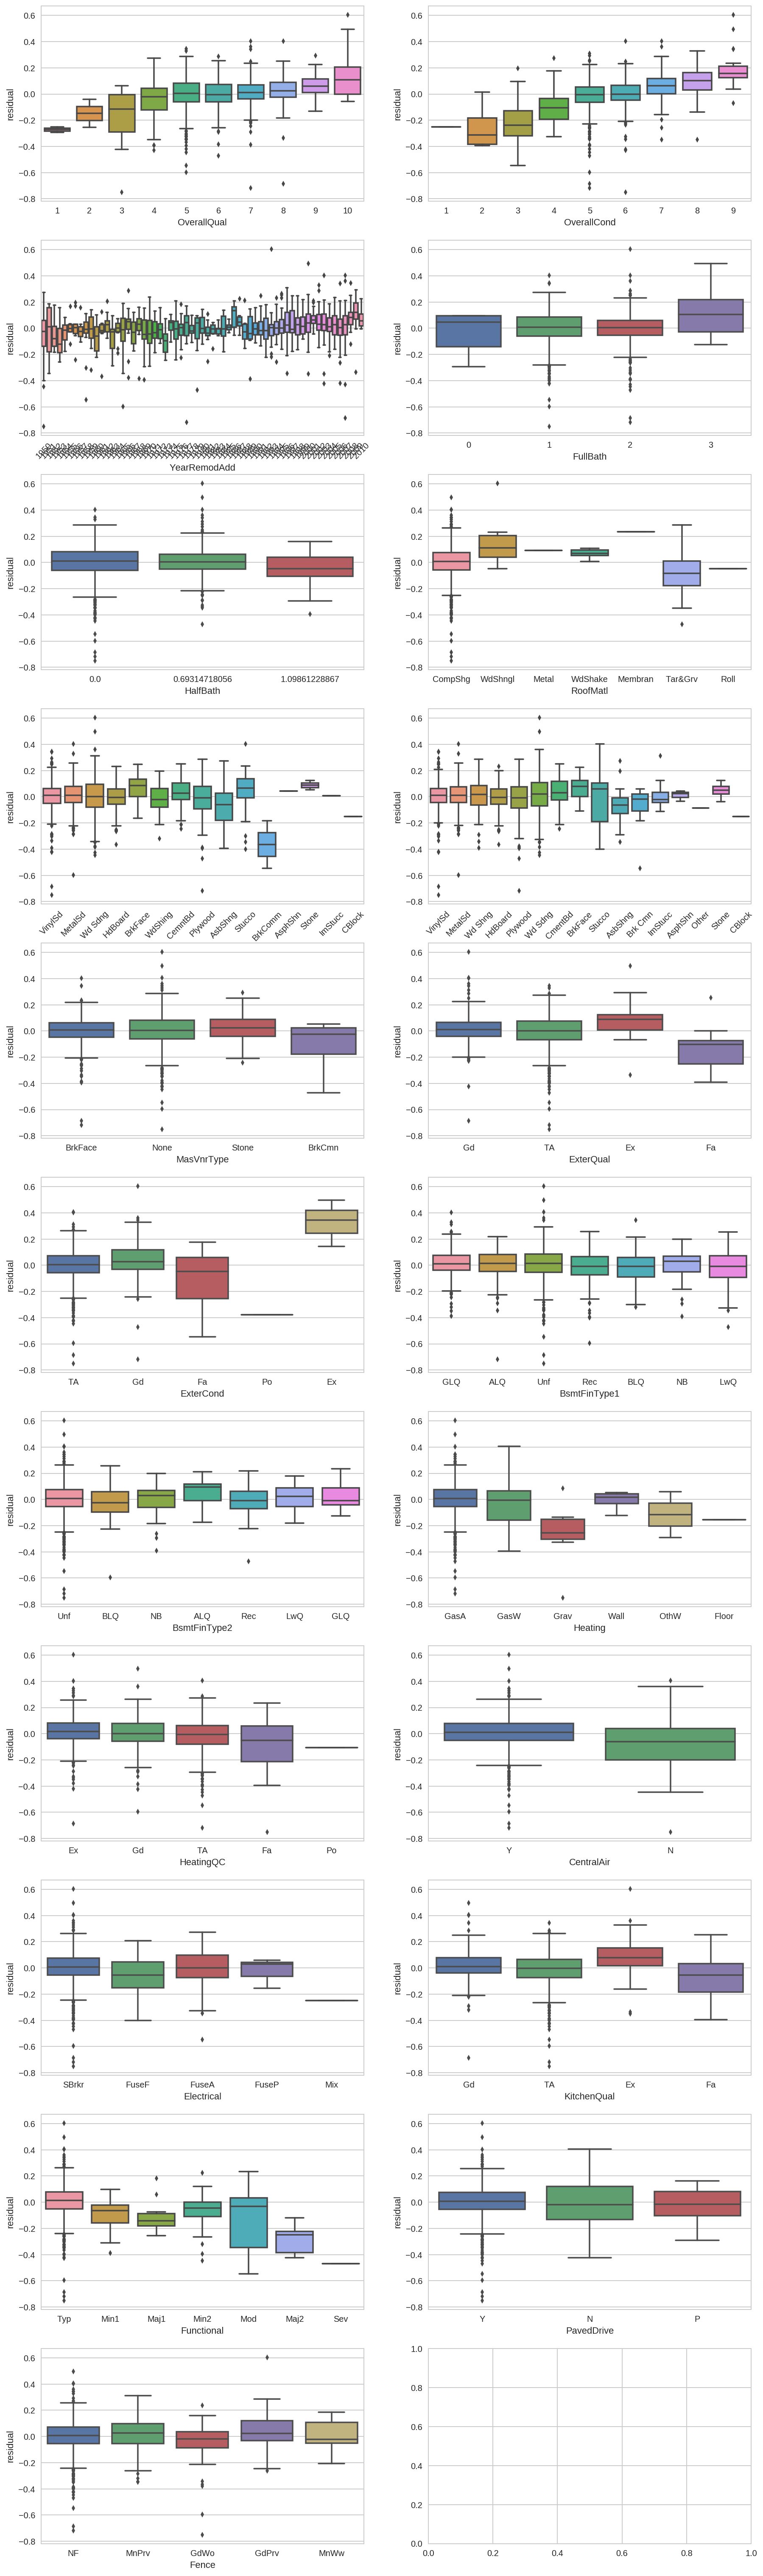

In [72]:
# look at box plots for categorical features
n_rows = int(np.ceil(len(fixable_discrete + fixable_categorical)/2.0))
fig, axes = plt.subplots(n_rows, 2, figsize=(15,5*n_rows))
for i,col in enumerate(fixable_discrete + fixable_categorical):
    sns.boxplot(x=col, y='residual', data=house, ax=axes[i//2,i%2])
    if col in ['YearRemodAdd', 'Exterior1st', 'Exterior2nd']:
        plt.sca(axes[i//2,i%2])
        plt.xticks(rotation=45)
plt.show()

**Note:**  
I don't really see any patterns in the data, except in OverallQual and OverallCond. With regard to these two features, it seems our SalePrice prediction model underpriced homes with high values in these features and overpriced those with low values. There seems to be no strong correlations to residual in the heatmap and the pair plots didn't reveal any apparent patterns. I don't believe a linear regression model is going to perform well, but that's where I'll start.

### 2.4 - Subset the data to just fixable features and get dummy variables.

In [73]:
# create a dataframe of fixable features
house_fixable = house.loc[:,fixable_features]
house_fixable.shape

(1377, 30)

In [74]:
# convert categorical columns to dummy variables
house_fixable = pd.get_dummies(house_fixable)
house_fixable.shape

(1377, 116)

### 2.5 - Split the data into train and test sets and fit models with residuals as the target.
I'm still using the pre-2010 properties as the training set and the 2010 properties as the test set.

In [75]:
X_train = house_fixable.loc[train_mask]
y_train = house.residual[train_mask]
X_test = house_fixable.loc[test_mask]
y_test = house.residual[test_mask]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1214, 116), (1214,), (163, 116), (163,))

#### Linear Regression

In [76]:
linreg_res = LinearRegression()

In [77]:
linreg_res.fit(X_train, y_train)
print(linreg_res.score(X_train, y_train))
print(linreg_res.score(X_test, y_test))

0.386784965017
0.245187953924


**Note:**  
Pretty low scores compared to the Part 1 model to predict SalePrice. Let's look at the coefficients for this model before trying to fit a different one.

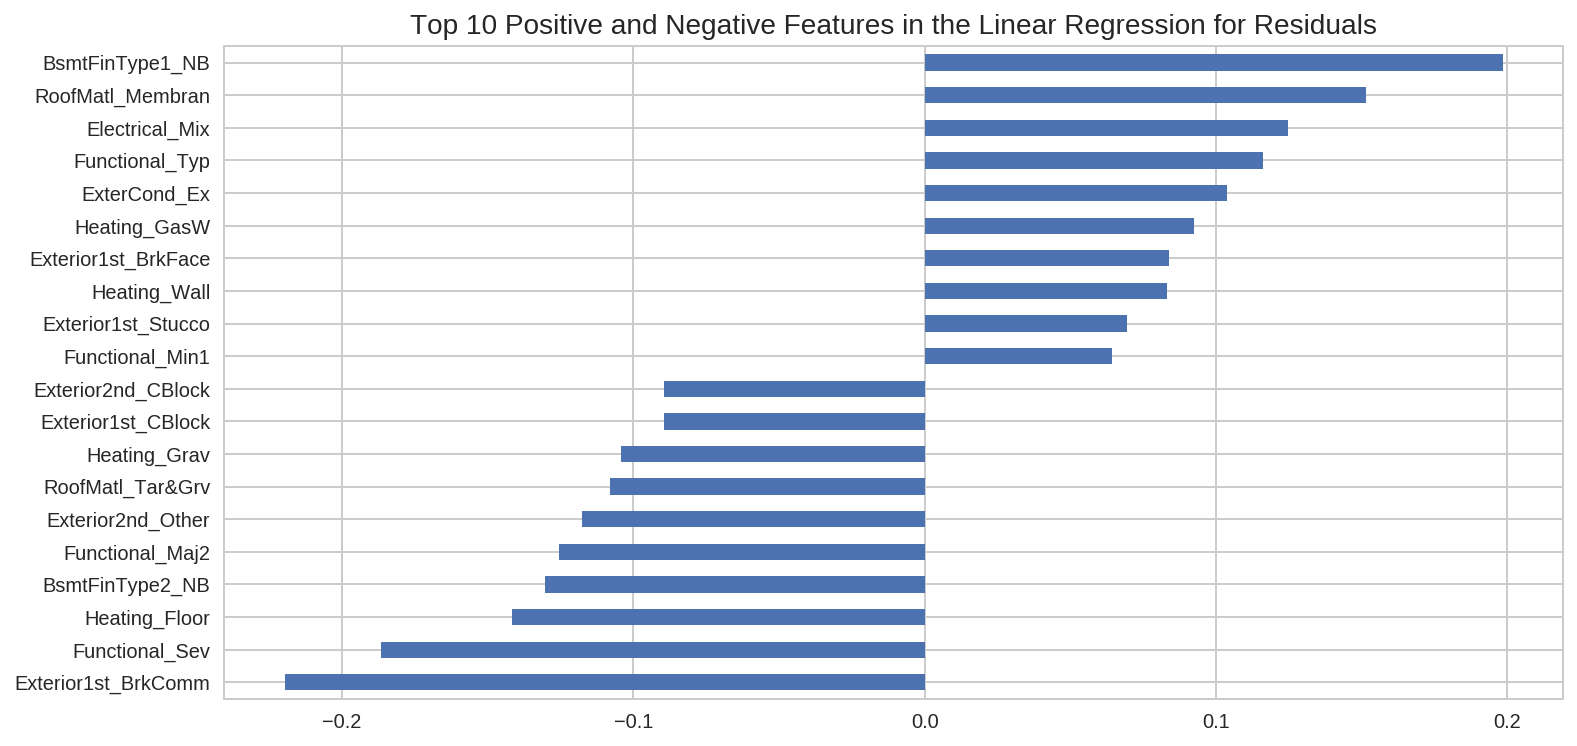

In [78]:
coefs_linreg_res = pd.Series(linreg_res.coef_, index = X_train.columns)
top20_coefs_linreg_res = pd.concat([coefs_linreg_res.sort_values(ascending=True).head(10),
                        coefs_linreg_res.sort_values(ascending=True).tail(10)])
fig = plt.figure(figsize=(12,6))
top20_coefs_linreg_res.plot(kind = "barh")
plt.title("Top 10 Positive and Negative Features in the Linear Regression for Residuals", fontsize=14)
plt.show()

#### Lasso
I'm gonna loop through to tune the alpha parameter.

In [79]:
results = []
for a in np.arange(0.0001, 0.0011, 0.0001):
    lasso_res = Lasso(alpha=a)
    lasso_res.fit(X_train, y_train)
    results.append({'alpha':a,
                    'train_score':lasso_res.score(X_train, y_train), 
                    'test_score':lasso_res.score(X_test, y_test)})
pd.DataFrame(results).T

,0,1,2,3,4,5,6,7,8,9
alpha,0.000100,0.000200,0.000300,0.000400,0.000500,0.000600,0.000700,0.000800,0.000900,0.001000
test_score,0.265264,0.273370,0.275916,0.277072,0.276571,0.274341,0.272660,0.272723,0.272475,0.272342
train_score,0.375230,0.363835,0.355179,0.347668,0.340076,0.333635,0.329172,0.326872,0.324330,0.321611


**Note:**  
It looks like alpha = 0.0004 gives the best test score. I'm going to fit with that alpha and take a look at the coefficients.

In [80]:
lasso_res = Lasso(alpha=0.0004)
lasso_res.fit(X_train, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso picked 51 features and eliminated 65 features


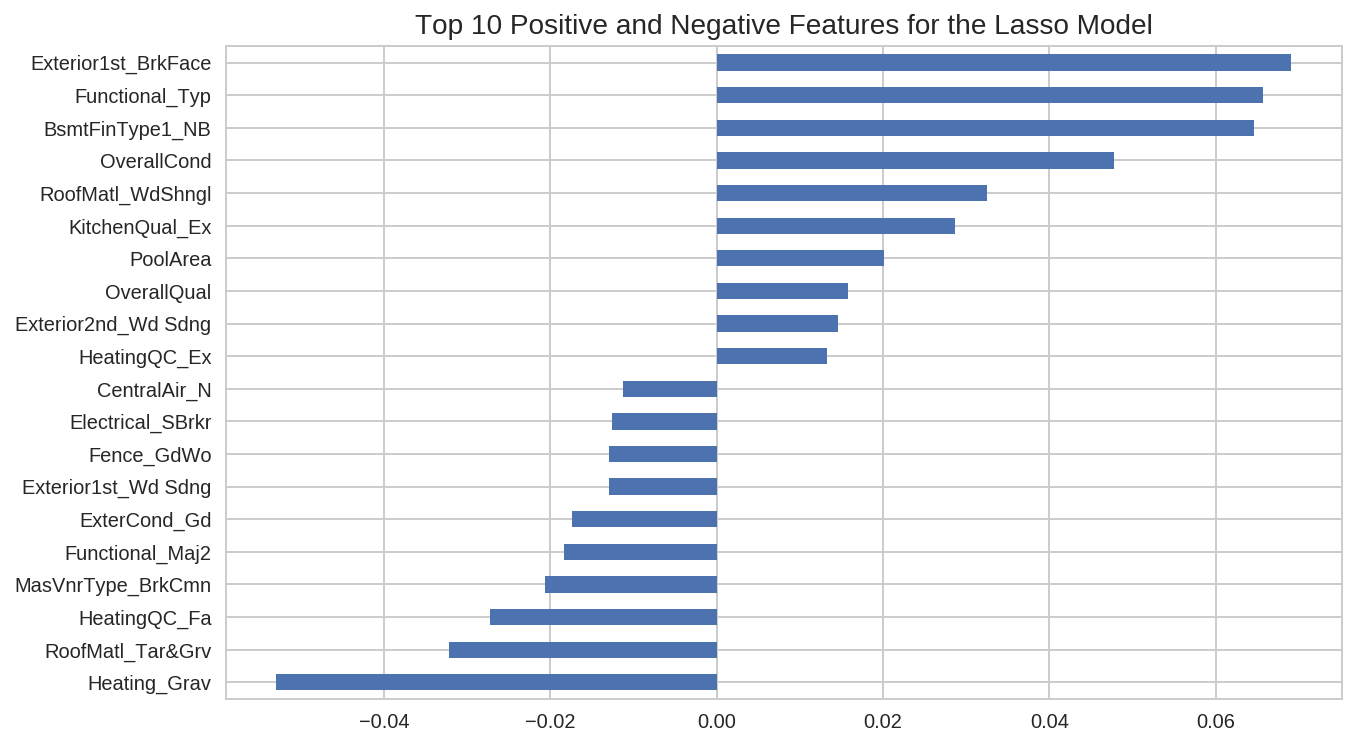

In [81]:
coefs_lasso_res = pd.Series(lasso_res.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs_lasso_res != 0)) + " features and eliminated " +
      str(sum(coefs_lasso_res == 0)) + " features")
top_coefs_lasso_res = pd.concat([coefs_lasso_res.sort_values(ascending=True).head(10),
                        coefs_lasso_res.sort_values(ascending=True).tail(10)])
fig = plt.figure(figsize=(10,6))
top_coefs_lasso_res.plot(kind = "barh")
plt.title("Top 10 Positive and Negative Features for the Lasso Model", fontsize=14)
plt.show()

# Continue here. Figure out a way to turn this into actual dollar figures.

**Summary:**  
Here's how I've interpreted these results. Admittedly, I haven’t been able to conceptualize this with specifics, so I’ll be sharing a broad overview. My first model can be used to predict the sale price of a home. My second model can explain about 27.7% of the variance in the difference between actual sale price and the price my first model predicts. Negative residuals in my first model indicate that it predicted a sale price higher than the actual sale price. My second model states that on average, we can recoup about 27.7% of that difference. The features in my second model that drive the residual down (thus meaning our predicted sale price is higher than actual) are those with negative coefficients.  For instance, looking at the chart above, gravity furnace heating, fair heating quality and condition, common brick veneer, fence with good wood, and standard circuit breaker electrical system are some of the features that cause my model to overvalue a home (negative residual). Finding homes with these features to be remodeled would lead to a profit on resale because it brings the value of the home closer to what my model predicted. This, of course, is assuming the renovation costs do not exceed the difference in value. I suspect my model can help calculate these numbers; however, I don’t exactly know how. This fact makes it difficult for me to assess the trustworthiness of my models. 